# Проект. Улучшение baseline-модели для Яндекс Недвижимости

## Описание проекта

**Компания:** Яндекс Недвижимость - маркетплейс для аренды и покупки жилой и коммерческой недвижимости.

**Задача:** Улучшить модель прогнозирования стоимости недвижимости на основе XGBoost алгоритма для увеличения количества успешных сделок на платформе.

**Цель:** Оптимизировать метрики модели через feature engineering, feature selection и hyperparameter tuning с полным логированием экспериментов в MLflow.

## Ключевые этапы улучшения модели:

- **Этап 1: Подготовка MLflow окружения** - Разворачивание и запуск сервисов MLflow в виде shell-скрипта (вне notebook): основа для работы с экспериментами и логирования результатов моделей.

- **Этап 2: Исследовательский анализ данных (EDA)** - Проведение анализа данных недвижимости для понимания их структуры и особенностей московского рынка.

- **Этап 3: Генерация признаков и обучение модели** - Создание новых признаков с помощью sklearn и autofeat, обучение XGBoost модели на обогащенном наборе данных.

- **Этап 4: Отбор признаков и обучение модели** - Выбор наиболее важных признаков с помощью Sequential Feature Selection для повышения качества XGBoost модели.

- **Этап 5: Подбор гиперпараметров и обучение модели** - Оптимизация гиперпараметров XGBoost с использованием Optuna и RandomizedSearchCV.

## Ожидаемый результат:
4 зарегистрированные версии XGBoost модели в MLflow Model Registry с улучшающимися метриками качества для прогнозирования стоимости недвижимости.

## Подготовка к анализу

В начале анализа мы импортируем необходимые библиотеки и загрузим данные недвижимости из CSV файла. Эти данные послужат основой для улучшения модели и последующего обучения XGBoost алгоритма:

### Используемые библиотеки:
- **pandas, numpy** - работа с данными и численными вычислениями
- **matplotlib, seaborn** - визуализация данных
- **xgboost** - основной алгоритм машинного обучения
- **sklearn** - предобработка данных и метрики
- **mlflow** - отслеживание экспериментов и управление моделями
- **optuna** - оптимизация гиперпараметров
- **autofeat** - автоматическая генерация признаков

In [45]:
# Импорты библиотек
import json
import os
import warnings
import yaml
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from autofeat import AutoFeatRegressor
import xgboost as xgb
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from optuna.integration.mlflow import MLflowCallback
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    cross_validate, 
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    KBinsDiscretizer,
    PolynomialFeatures, 
    RobustScaler
)
from sklearn.compose import ColumnTransformer

# Загрузка конфигурации
def load_config():
    config_path = "../config.yaml"
    with open(config_path, 'r', encoding='utf-8') as f:
        return yaml.safe_load(f)

config = load_config()

# Константы из конфигурации
RANDOM_STATE = config['train']['random_state']
TEST_SIZE = config['train']['test_size']
TARGET_COLUMN = config['preprocessing']['features']['target_column']
DROP_COLUMNS = config['preprocessing']['features']['drop_columns']

# Константы MLflow из конфигурации
EXPERIMENT_NAME = config['mlflow']['experiment_name']
TRACKING_SERVER_HOST = config['mlflow']['tracking_server_host']
TRACKING_SERVER_PORT = config['mlflow']['tracking_server_port']

# Данные
DATA_PATH = config['automation']['data_paths']['initial_data']

# Настройка параметров отображения данных
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64
sns.set_theme(style="ticks", palette="pastel")

# Дополнительные настройки
warnings.filterwarnings("ignore")
# mlflow.xgboost.autolog()

print("✅ Конфигурация и переменные загружены")

✅ Конфигурация и переменные загружены


In [46]:
# Проверяем существование файла
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Файл данных не найден: {DATA_PATH}")

# Загружаем данные
# Загружаем данные с оптимизацией типов для экономии памяти
df = pd.read_csv(DATA_PATH, dtype={
    "rooms": "category",
    "building_type": "category",
    "floor": "int16",
    "floors_total": "int16",
    "flats_count": "int32",
    "build_year": "int16",
    "is_apartment": "bool",
    "studio": "bool",
    "has_elevator": "bool"
})

# Проверяем экономию памяти
print(f"   Размер: {df.shape[0]:,} строк × {df.shape[1]} столбцов")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Удаляем ненужные столбцы согласно конфигурации (векторная операция)
columns_to_drop = list(set(df.columns) & set(DROP_COLUMNS))
if columns_to_drop:
    df.drop(columns_to_drop, axis=1, inplace=True)

print(f"   Размер: {df.shape[0]:,} строк × {df.shape[1]} столбцов")

df.head(3)

   Размер: 120,118 строк × 18 столбцов
   Memory usage: 10.0 MB
   Размер: 120,118 строк × 16 столбцов


,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,9,9.9,19.9,1,False,False,35.099998,9500000,1965,6,55.717113,37.781120,2.64,84,12,True
1,7,0.0,16.6,1,False,False,43.000000,13500000,2001,2,55.794849,37.608013,3.00,97,10,True
2,9,9.0,32.0,2,False,False,56.000000,13500000,2000,4,55.740040,37.761742,2.70,80,10,True


## Подготовка данных недвижимости

Мы успешно загрузили данные о недвижимости из CSV файла в pandas DataFrame. Этот датасет содержит предобработанные данные о квартирах в Москве, которые были подготовлены в рамках предыдущего проекта.

> ### Разделение выборок
> Для объективной оценки производительности модели и управления риском переобучения используется стратегия **train/test с кросс-валидацией**:
> 
> 1. **Разделение на train/test** - данные делятся на обучающую (80%) и тестовую (20%) выборки
> 2. **Кросс-валидация на train** - для настройки гиперпараметров и оценки стабильности модели
> 3. **Финальная оценка на test** - для получения объективных метрик качества модели
>
> Такой подход оптимален для нашего объёма данных и обеспечивает надёжную валидацию результатов.

### Разделение данных:
* **Обучающая выборка (80%)** - для тренировки XGBoost модели и кросс-валидации
* **Тестовая выборка (20%)** - для финальной независимой оценки качества модели

### Особенности данных недвижимости:
- Географические координаты (широта, долгота)
- Характеристики квартир (площадь, комнаты, этаж)
- Параметры зданий (тип, год постройки, лифт)
- Целевая переменная: цена квартиры в рублях

In [47]:
# Разделение данных на признаки и целевую переменную
target = df[TARGET_COLUMN].copy()
features = df.drop(TARGET_COLUMN, axis=1).copy()

# Предобработка данных согласно конфигурации
numerical_features = config['preprocessing']['features'].get('numerical_features', [])
categorical_features = config['preprocessing']['features'].get('categorical_numeric_features', [])
boolean_features = config['preprocessing']['features'].get('boolean_features', [])

print(f"Числовые признаки: {numerical_features}")
print(f"Категориальные признаки: {categorical_features}")
print(f"Булевы признаки: {boolean_features}")

# Разделение на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=config['train']['shuffle']
)

# Информация о разделении данных
print(f"\nРАЗДЕЛЕНИЕ ДАННЫХ:")
print(f"   Полный датасет: {features.shape[0]:,} × {features.shape[1]}")
print(f"   Обучающая выборка: {features_train.shape[0]:,} × {features_train.shape[1]}")
print(f"   Тестовая выборка: {features_test.shape[0]:,} × {features_test.shape[1]}")


Числовые признаки: ['floor', 'kitchen_area', 'living_area', 'total_area', 'build_year', 'latitude', 'longitude', 'ceiling_height', 'flats_count', 'floors_total']
Категориальные признаки: ['rooms', 'building_type']
Булевы признаки: ['is_apartment', 'studio', 'has_elevator']

РАЗДЕЛЕНИЕ ДАННЫХ:
   Полный датасет: 120,118 × 15
   Обучающая выборка: 96,094 × 15
   Тестовая выборка: 24,024 × 15


# Этап 2: Исследовательский анализ данных (EDA)

## Цель этапа:
Провести тщательный исследовательский анализ данных недвижимости, чтобы глубже понять особенности и связи в предоставленном наборе данных.

### Рекомендуемые шаги исследования:
1. **Понимание данных**: Ознакомление с данными, изучение типов данных, проверка наличия пропущенных значений
2. **Визуализация данных**: Использование графиков и диаграмм для визуализации распределений признаков и взаимосвязей
3. **Статистический анализ**: Применение статистических методов для изучения центральных тенденций, разброса и корреляций
4. **Предварительные выводы**: Формулирование выводов о данных для дальнейшего моделирования

### Ключевые аспекты для анализа:
- Распределения цен на московском рынке недвижимости
- Взаимосвязей между характеристиками квартир и их стоимостью
- Выявления аномалий и выбросов в данных
- Географических особенностей ценообразования

### Важно:
EDA - это итеративный процесс, в котором можно возвращаться к предыдущим шагам для дополнительного анализа. Все находки и выводы должны быть чётко зафиксированы и залогированы в MLflow.

Результаты EDA помогут принять обоснованные решения при создании признаков и настройке XGBoost модели.

## Базовый анализ данных недвижимости

### Первичный осмотр данных

Начнём с изучения структуры нашего датасета недвижимости:
- Краткая сводка по количеству записей и признакам
- Анализ типов данных (числовые, категориальные, булевы)
- Проверка на наличие пропущенных значений
- Оценка качества и полноты данных

Это даст нам понимание базовых характеристик датасета перед углублённым анализом.

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120118 entries, 0 to 120117
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   floor           120118 non-null  int16   
 1   kitchen_area    120118 non-null  float64 
 2   living_area     120118 non-null  float64 
 3   rooms           120118 non-null  category
 4   is_apartment    120118 non-null  bool    
 5   studio          120118 non-null  bool    
 6   total_area      120118 non-null  float64 
 7   price           120118 non-null  int64   
 8   build_year      120118 non-null  int16   
 9   building_type   120118 non-null  category
 10  latitude        120118 non-null  float64 
 11  longitude       120118 non-null  float64 
 12  ceiling_height  120118 non-null  float64 
 13  flats_count     120118 non-null  int32   
 14  floors_total    120118 non-null  int16   
 15  has_elevator    120118 non-null  bool    
dtypes: bool(3), category(2), float64(6), i

### Результаты первичного анализа

Мы видим, что очищенные данные представляют базу объектов недвижимости, где каждому объекту присвоена цена для обучения модели прогнозирования стоимости. 

**Ключевые выводы:**
- Количество записей соответствует размеру нашего датасета
- Все столбцы содержат полные данные без пропусков
- Структура данных готова для машинного обучения

Давайте дополнительно проверим отсутствие пропущенных значений:

In [51]:
df.isnull().sum().sort_values(ascending=False)

floor             0
kitchen_area      0
living_area       0
rooms             0
is_apartment      0
studio            0
total_area        0
price             0
build_year        0
building_type     0
latitude          0
longitude         0
ceiling_height    0
flats_count       0
floors_total      0
has_elevator      0
dtype: int64

### Анализ типов данных

Теперь рассмотрим типы данных, представленные в столбцах нашего датасета недвижимости:

In [52]:
df.dtypes

floor                int16
kitchen_area       float64
living_area        float64
rooms             category
is_apartment          bool
studio                bool
total_area         float64
price                int64
build_year           int16
building_type     category
latitude           float64
longitude          float64
ceiling_height     float64
flats_count          int32
floors_total         int16
has_elevator          bool
dtype: object

### Структура типов данных недвижимости

Данные преимущественно представлены целочисленными (int) и числовыми с плавающей точкой (float) типами данных, а также (в меньшей степени) булевыми типами для бинарных характеристик (наличие лифта, тип квартиры).

**Типы признаков:**
- **Числовые:** площади, координаты, высота потолков, этаж
- **Целочисленные:** количество комнат, этажность, год постройки  
- **Булевы:** наличие лифта, тип недвижимости, студия

## Анализ признаков для модели недвижимости

### Цель анализа:
Изучить взаимосвязи между характеристиками квартир и их влияние на цену недвижимости в Москве для эффективного обучения XGBoost модели.

### Исследование признаков недвижимости

Следующим шагом будет изучение признаков, которые будут участвовать в процессе моделирования цен недвижимости. Давайте отобразим первую строку DataFrame, чтобы увидеть пример одного объекта недвижимости с его характеристиками:

In [53]:
features.head(1)

,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,build_year,building_type,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,9,9.9,19.9,1,False,False,35.099998,1965,6,55.717113,37.78112,2.64,84,12,True


### Анализ площадей по типам зданий

Теперь мы можем начать рассматривать признаки недвижимости с разных сторон. Давайте изучим общую площадь в зависимости от типов зданий с дополнительной фильтрацией по количеству комнат в квартире:

2025-08-13 18:13:27,376 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-13 18:13:27,470 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


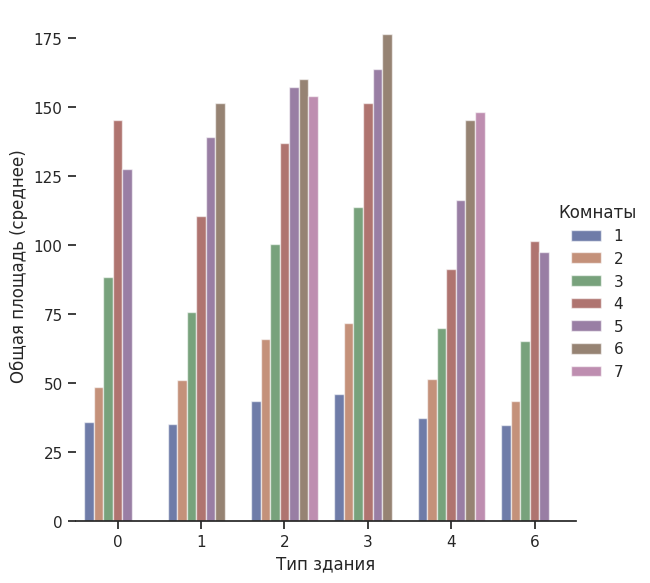

In [54]:
cat_plot = sns.catplot(
    data=features, kind="bar", x="building_type", 
    y="total_area", hue="rooms", errorbar=None, 
    palette='dark', alpha=.6, height=6,
)
cat_plot.despine(left=True)
cat_plot.set_axis_labels("Тип здания", "Общая площадь (среднее)")
cat_plot.legend.set_title("Комнаты")

На графике выше мы можем заметить, что с увеличением количества комнат общая площадь в среднем также увеличивается, что логично. Таким образом, видн, что выбранное разделение данных правильное и не содержит противоречивой или аномальной информации. Некоторые здания могут характеризоваться тем, что в них нет квартир с 4 или 5 комнатами. Особенно можно отметить здания типов 1, 2 и 3, где наибольшие средние площади характерны для квартир с 5 комнатами.

Теперь рассмотрим распределение высоты потолков в зависимости от количества комнат в недвижимости Яндекс.Недвижимости. Отдельно выделим квартиры, классифицированные как апартаменты:

2025-08-13 18:27:07,825 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-13 18:27:07,873 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-13 18:27:07,886 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


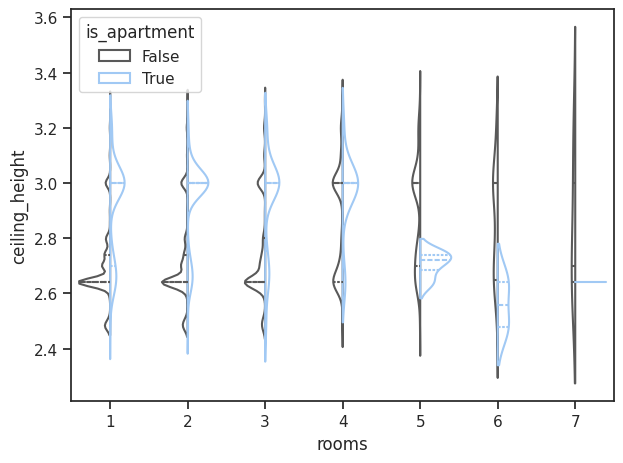

In [58]:
violin_plot = sns.violinplot(
    data=features, x="rooms", y="ceiling_height", 
    hue="is_apartment", split=True, inner="quart", 
    fill=False, palette={True: "b", False: ".35"},
)
plt.tight_layout()
plt.show()

Что касается квартир с 1-3 комнатами (не апартаментов), большинство потолков имеют высоту около 2,6 метра, и таких квартир довольно много. Однако по мере увеличения количества комнат в таких квартирах данные о высоте потолков становятся более разнообразными, что можно увидеть по изменению колокообразной кривой на более плоскую.

Что касается апартаментов, распределение высот потолков характеризуется бимодальными кривыми, где для квартир с 1-3 комнатами высота варьируется от 2,6 метра до 3,0 метров. Высота потолков в 4-комнатных квартирах составляет около 3,0 метров.

Далее рассмотрим данные с статистической точки зрения: построим корреляционную матрицу признаков в виде тепловой карты:

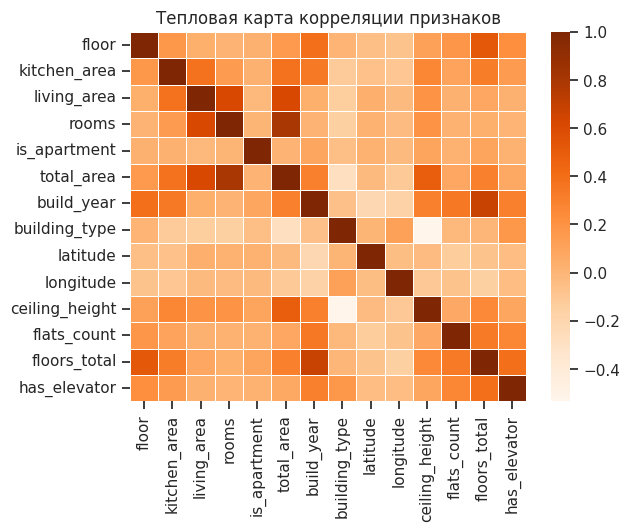

rooms             0.790948
living_area       0.618574
ceiling_height    0.485287
kitchen_area      0.372023
build_year        0.301856
Name: total_area, dtype: float64

In [59]:
corr_matrix = features.drop('studio', axis=1).corr()
corr_heatmap = sns.heatmap(
        corr_matrix, 
        linewidth=.5,
        cmap='Oranges',
    )
corr_heatmap.xaxis.tick_bottom()
corr_heatmap.yaxis.tick_left()
corr_heatmap.set(title="Тепловая карта корреляции признаков")
plt.show()

corr_total_area_5 = corr_matrix["total_area"].abs().sort_values(ascending=False)[1:].head()
display(corr_total_area_5)

По тепловой карте, а также по наивысшим значениям корреляции (по абсолютной величине) мы можем видеть, что общая площадь зависит от количества комнат, площадей кухни/гостиной, высоты потолков и количества этажей.

Также рассмотрим бинарные и другие колонки отдельно. Построим гистограммы для целочисленных и вещественных колонок:

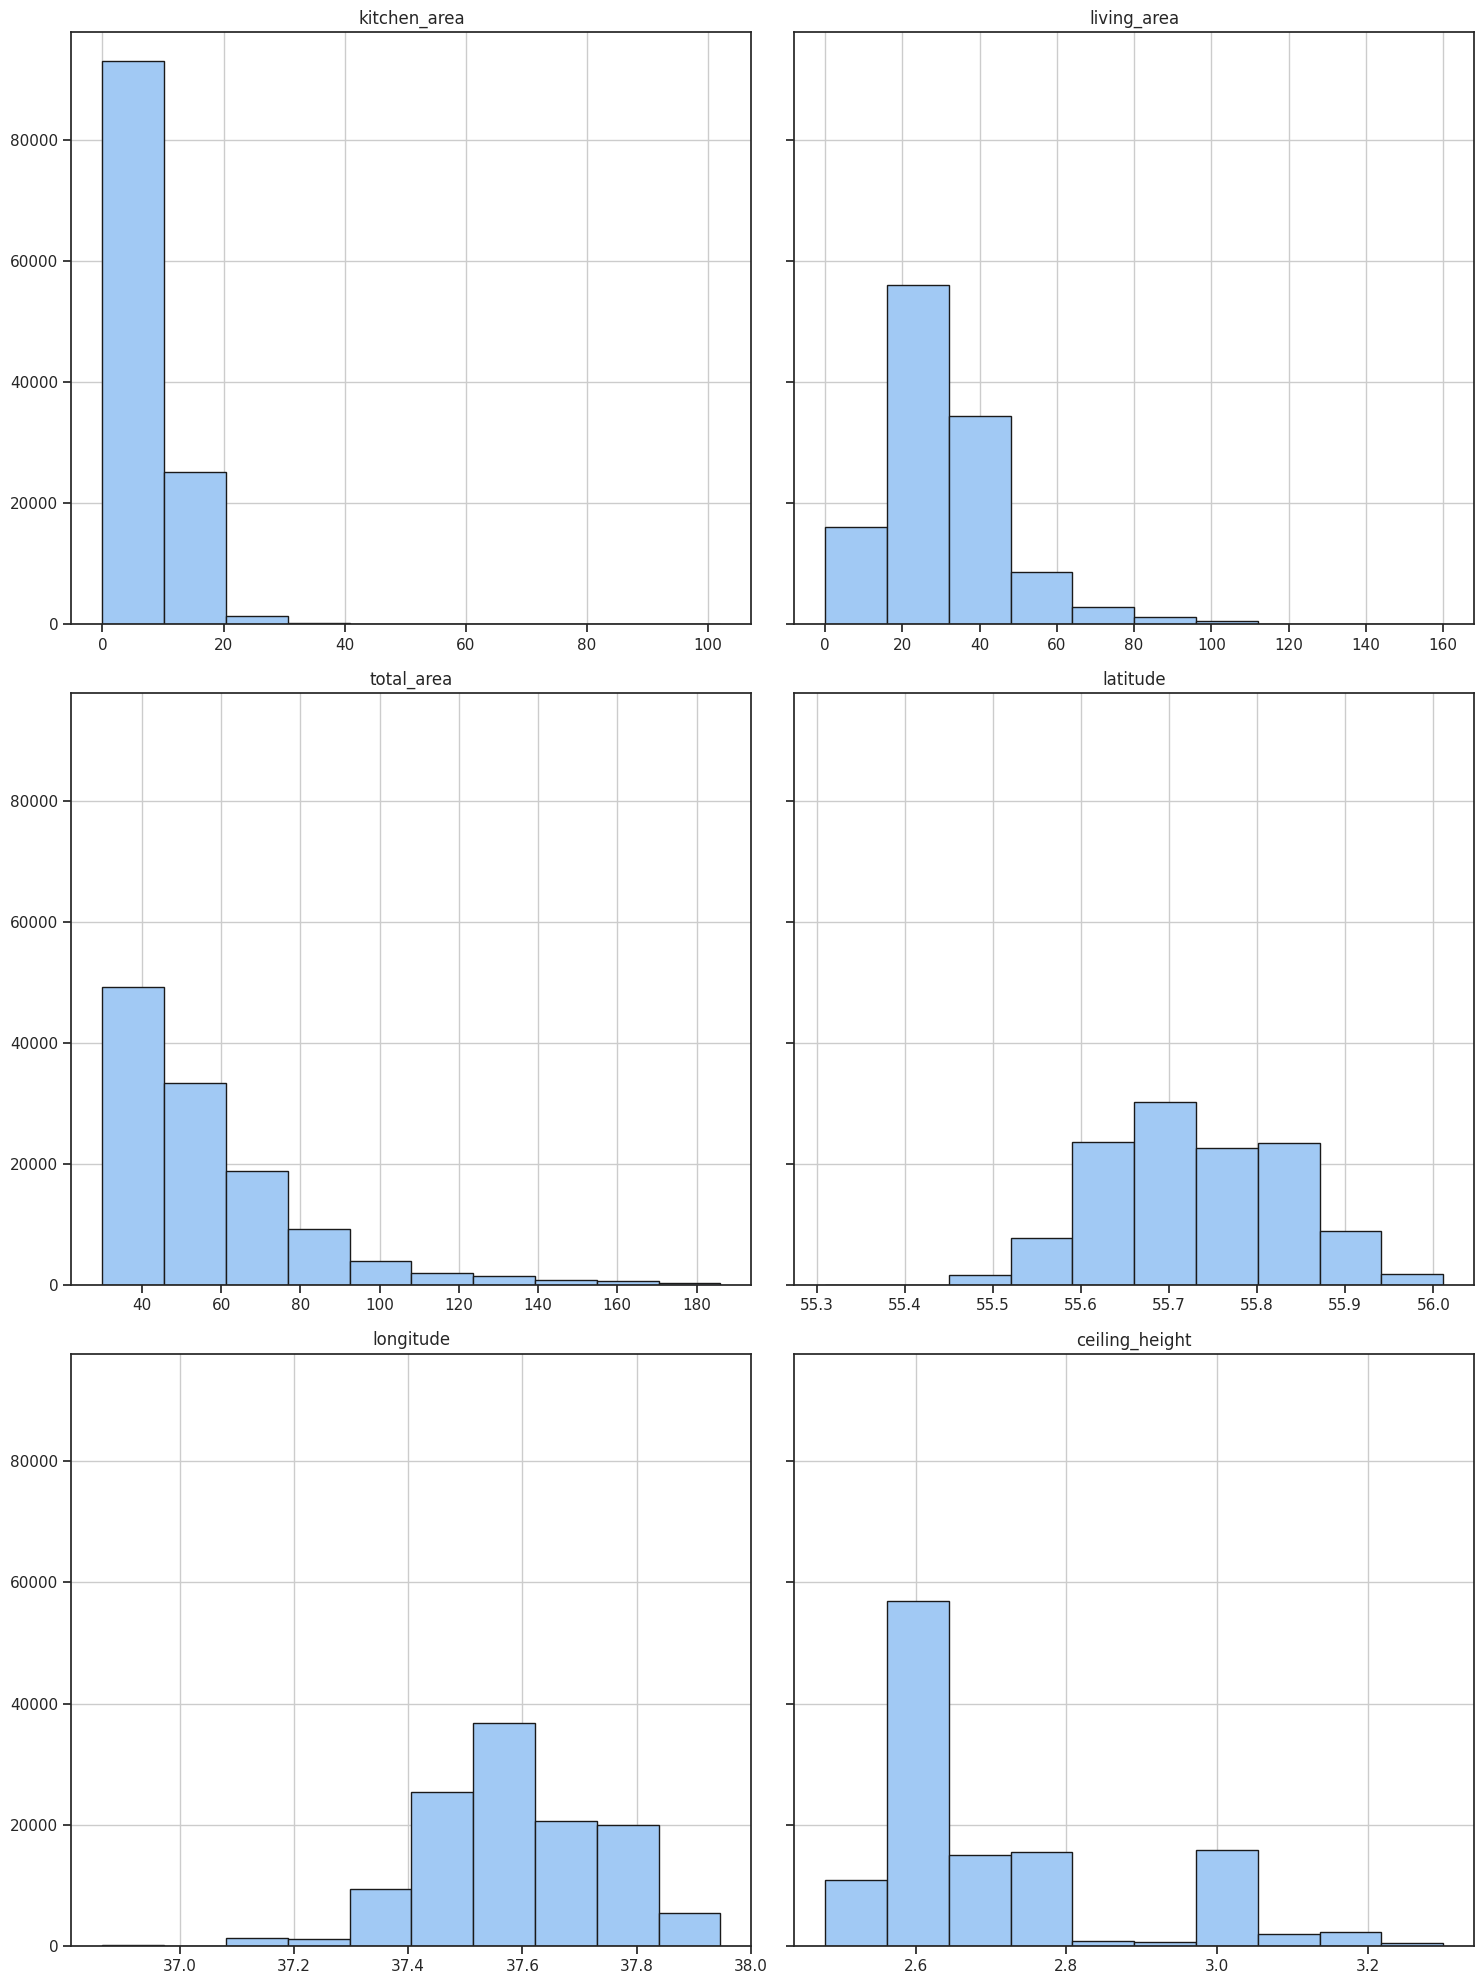

,count,mean,std,min,25%,50%,75%,max
kitchen_area,120118.0,8.787527,4.390607,0.000000,6.200000,8.700000,10.100000,102.000000
living_area,120118.0,29.510261,18.068513,0.000000,19.000000,29.100000,40.000000,160.000000
total_area,120118.0,57.178379,23.989388,30.000000,39.000000,52.000000,66.000000,186.000000
latitude,120118.0,55.729653,0.102923,55.309727,55.652493,55.719009,55.810017,56.011032
longitude,120118.0,37.592647,0.152252,36.864372,37.491287,37.581387,37.707558,37.946411
ceiling_height,120118.0,2.719910,0.165103,2.480000,2.640000,2.640000,2.750000,3.300000


In [60]:
# Plotting histograms for int64/float64-features
df_nobool = features.select_dtypes(include=["int64", "float64"])
df_nobool.hist(figsize=(15, 20), edgecolor="k", sharey=True)
plt.tight_layout()
plt.show()

# Displaying descriptive stats for int64-features
display(df_nobool.describe().T)

Мы наблюдаем, что большинство колонок описываются асимметричными или дискретными распределениями. 

Бинарные признаки:

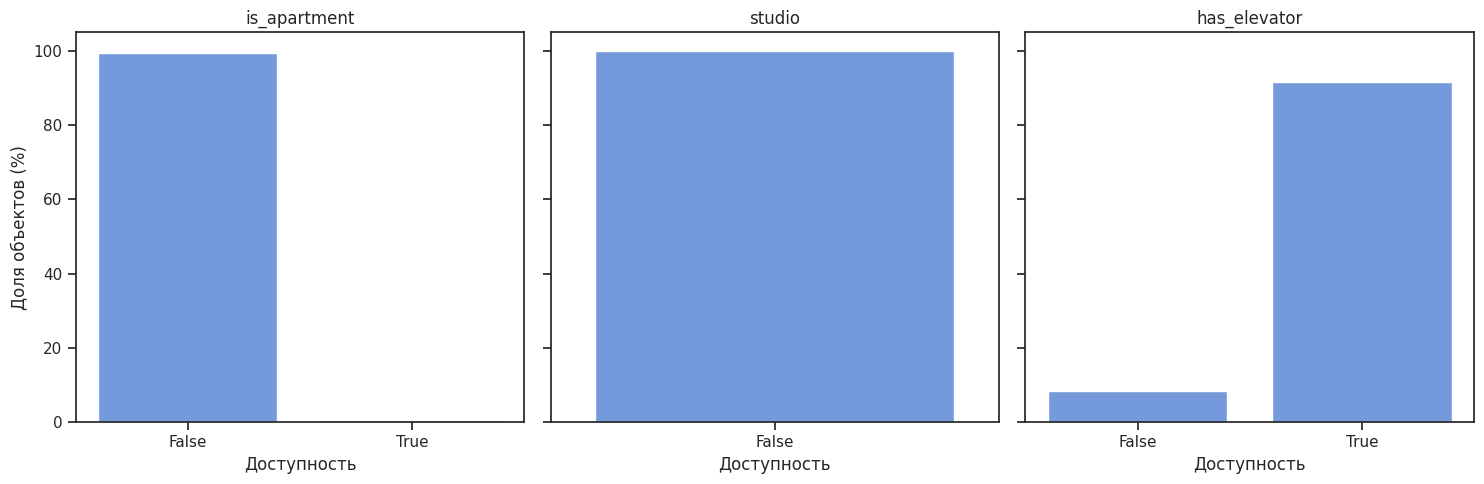

In [ ]:
# Анализ бинарных признаков
df_bool = df.select_dtypes(include="bool")
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for col, ax in zip(df_bool.columns.tolist(), axes):
    sns.countplot(x=col, data=df_bool, ax=ax, color="cornflowerblue", stat="percent")
    ax.set_xlabel("Доступность")
    ax.set_ylabel("Доля объектов (%)")
    ax.set_title(col)
plt.tight_layout()
plt.show()

Можно заметить, что в данных нет квартир-студий вообще, и что наиболее частые объекты в данных относятся к квартирам, которые не являются апартаментами и в которых есть лифт.

Наконец, мы можем рассмотреть столбцы, которые больше всего влияют на общую площадь, и визуализировать их в зависимости от количества комнат, которое также является важным фактором:

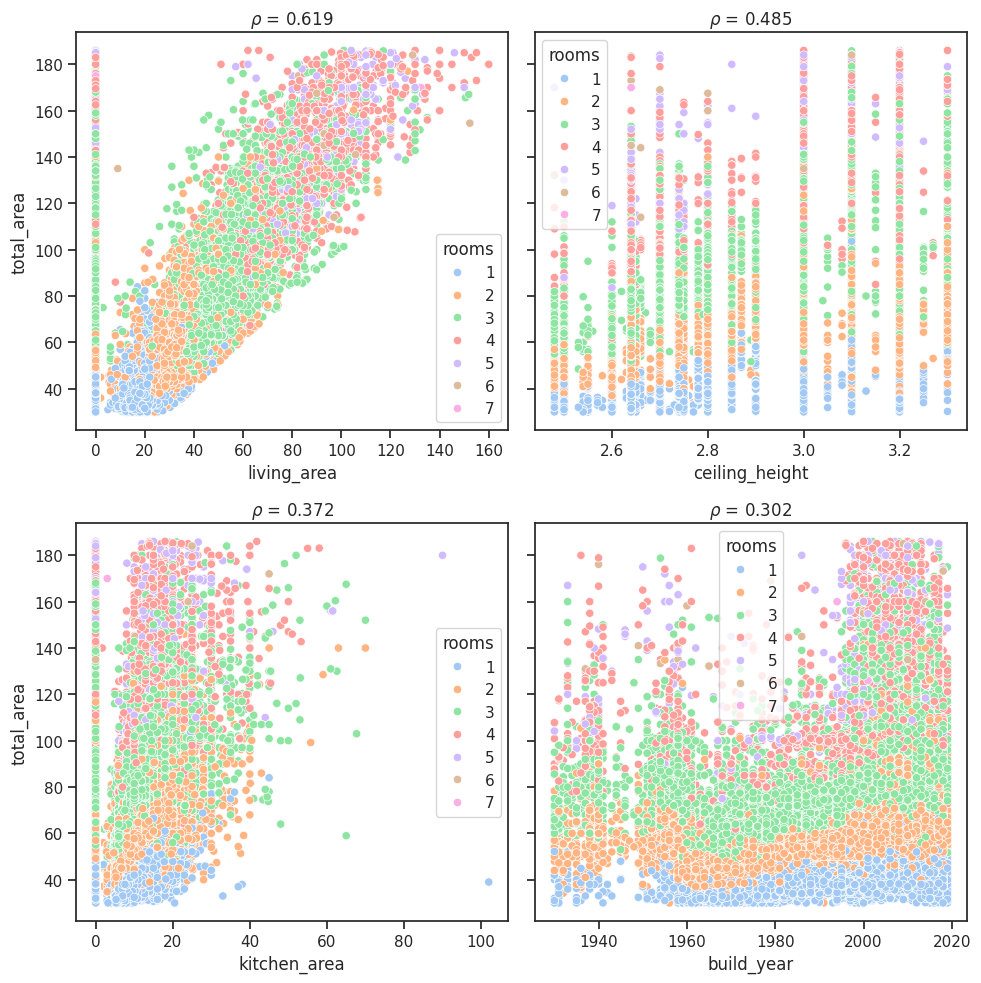

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
cols = corr_total_area_5.index[1:].tolist()
for col, ax in zip(cols, axes.flat):
    sns.scatterplot(data=df, x=col, y="total_area", hue="rooms", ax=ax)
    ax.set_title(fr"$\rho$ = {corr_total_area_5[col]:.3f}")
plt.tight_layout()
plt.show()

Этот график характеризуется наличием цветового градиента, который указывает на более высокие значения общей площади с увеличением количества комнат. Кроме того, анализируя два верхних графика, мы можем заметить выступающий столбец точек в нуле слева - это результат наличия нулевых значений для площадей кухни и гостиной в данных, которые могут быть либо аномалией, либо значениями, не указанными на сайте, но установленными в ноль системой по какой-то причине.

##### Target analysis

Перейдем к целевой переменной. Построим серию гистограмм с разбивкой по количеству комнат, типу здания и наличию лифта:

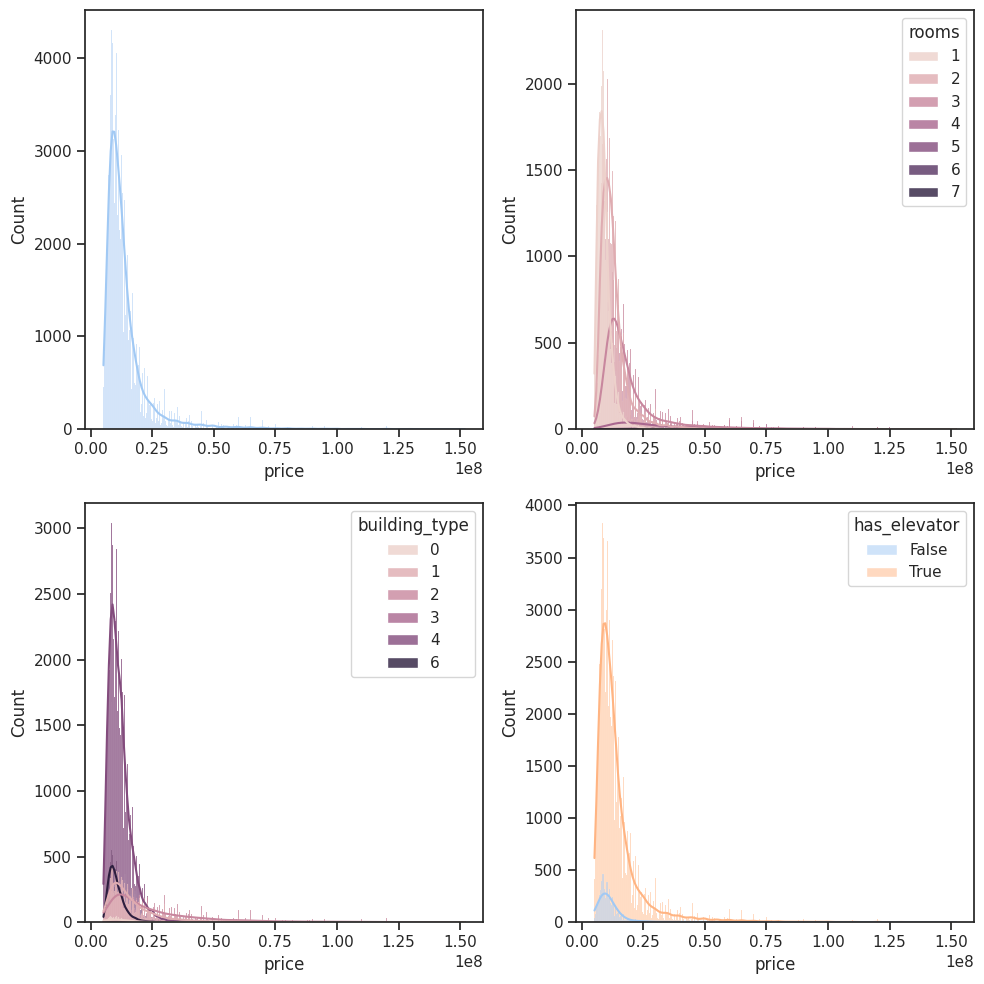

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(data=df, x='price', kde=True, ax=axes[0][0])
sns.histplot(data=df, x='price', hue="rooms", alpha=0.8, kde=True, ax=axes[0][1])
sns.histplot(data=df, x='price', hue="building_type", alpha=0.8, kde=True, ax=axes[1][0])
sns.histplot(data=df, x='price', hue="has_elevator", alpha=0.5, kde=True, ax=axes[1][1])
plt.tight_layout()
plt.show()

Мы можем заметить не только то, что квартир с лифтом больше, чем без него, но и то, что такие квартиры характеризуются более высокими ценами. Квартиры в зданиях типов 2, 3 и 4 имеют самые высокие цены, где квартиры из зданий типа 4 преобладают по количеству. Распределение цен описывается скошенной кривой, что можно заметить на левом верхнем графике.

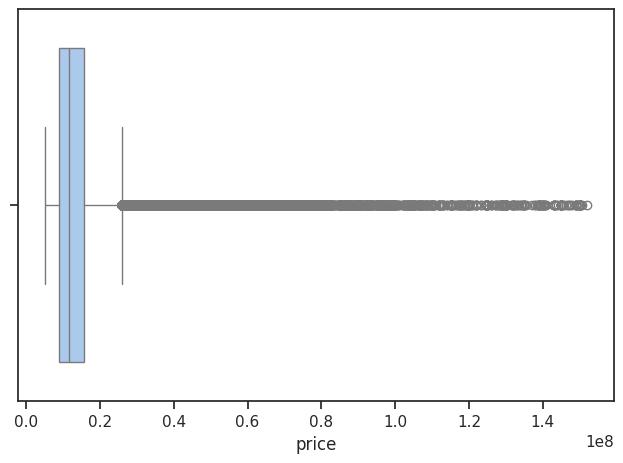

In [19]:
sns.boxplot(data=df, x='price')
plt.tight_layout()
plt.show()

Здесь можно наблюдать не только очень высокие цены (что разумно для цен на квартиры), но и нулевые, которые могут быть аномалиями.

##### Target analysis depending on different features

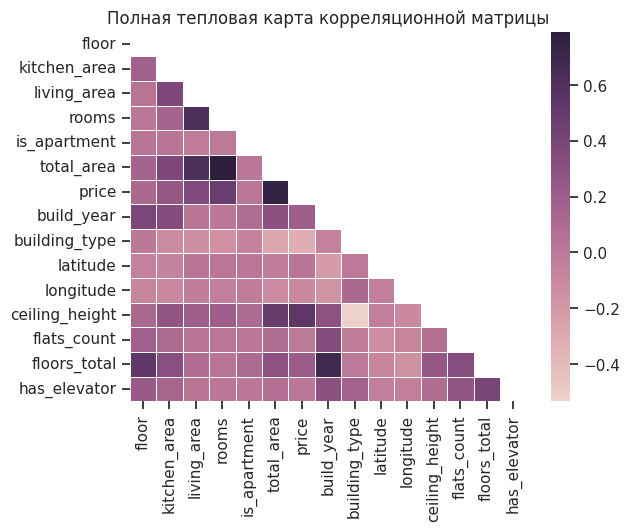

total_area        0.747813
ceiling_height    0.542401
rooms             0.477043
living_area       0.365343
building_type     0.324377
Name: price, dtype: float64

In [66]:
corr_matrix = df.drop('studio', axis=1).corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
corr_heatmap = sns.heatmap(
        corr_matrix, 
        linewidth=.5,
        mask=mask,
        cmap=sns.cubehelix_palette(as_cmap=True),
    )
corr_heatmap.xaxis.tick_bottom()
corr_heatmap.yaxis.tick_left()
corr_heatmap.set(title="Полная тепловая карта корреляционной матрицы")
plt.show()

price_factors_5 = corr_matrix["price"].abs().sort_values(ascending=False)[1:].head()
display(price_factors_5)

Можно заметить, что такие факторы, как общая площадь квартиры и количество комнат, оказывают существенное влияние на целевую переменную, что следует учитывать при построении модели прогнозирования.

Теперь построим совместные графики гистограмм и диаграмм рассеяния для топ-5 факторов, влияющих на целевую переменную:

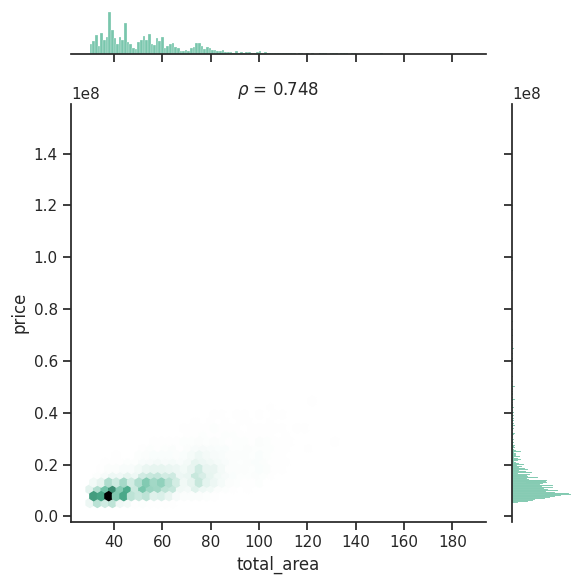

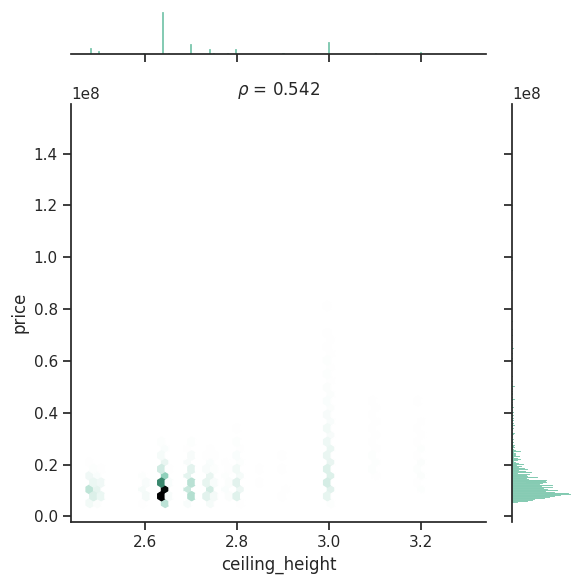

TypeError: unsupported operand type(s) for -: 'str' and 'str'

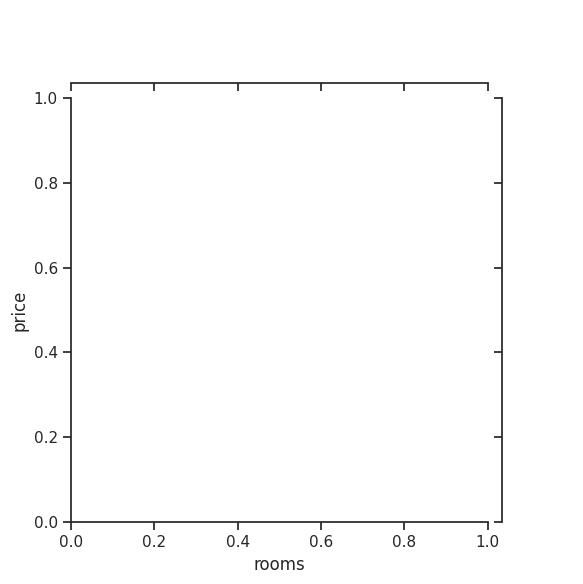

In [68]:
for col in price_factors_5.index.tolist():
    sns.jointplot(data=df, x=col, y="price", kind="hex", color="#4CB391")
    plt.title(fr"$\rho$ = {price_factors_5[col]:.3f}")
    plt.tight_layout()
    plt.show()

## Выводы исследовательского анализа данных (EDA)

### Ключевые выводы по рынку недвижимости Москвы:

Теперь, после проведения исследовательского анализа данных, мы можем обобщить наши ключевые наблюдения по московскому рынку недвижимости:

### 1. Взаимосвязь площадей и комнат:
В начале анализа была выдвинута гипотеза о влиянии количества комнат на общую площадь квартиры, что, в свою очередь, может влиять на её цену. Изучение корреляционных матриц показало, что количество комнат, а также площади кухни и жилых комнат сильно коррелируют с общей площадью, что соответствует не только данным, но и здравому смыслу. Кроме того, количество квартир в здании и высота потолков имеют положительную корреляцию с этой переменной.

### 2. Факторы ценообразования недвижимости:
После добавления целевой переменной в корреляционную матрицу мы установили, что общая площадь и количество комнат являются двумя основными факторами, влияющими на цены квартир. Если ранее мы обнаружили значительное влияние количества комнат на общую площадь, то дополнительно подтвердили, что общая площадь квартиры прямо пропорциональна количеству комнат, и цена формируется на основе общей площади квартиры.

### 3. Ключевые признаки для моделирования:
Факторы, которые необходимо учитывать при построении модели XGBoost:
- **Общая площадь** (основной фактор ценообразования)
- **Площадь кухни** (влияет на функциональность)
- **Жилая площадь** (определяет комфорт)
- **Высота потолков** (показатель качества жилья)
- **Количество комнат** (базовая характеристика планировки)

### 4. Выявленные аномалии:
Обнаружено наличие очень низких значений в столбцах с ценами и площадями кухни/жилых комнат. Это может быть связано с системными ошибками, когда пустые значения в формах на сайте были заменены нулями, или с реальными аномалиями рынка (например, студии без отдельных зон).

### Рекомендации для улучшения модели:
1. Использовать логарифмическое преобразование цен для нормализации распределения
2. Создать дополнительные признаки: цена за квадратный метр, соотношения площадей
3. Обработать географические признаки: расстояние до центра, районы Москвы
4. Применить регуляризацию в XGBoost для борьбы с переобучением

В результате разведочного анализа данных были найдены дубликаты и пропущенные значения, поскольку таблица, взятая из базы данных, представляет данные, которые уже были очищены от таких. Тем не менее, на основе диаграмм рассеяния и описательной статистики можно заметить очень низкие значения цен и площадей кухни и гостиной. Поскольку очистка данных проводилась с помощью межквартильного размаха, для некоторых колонок была вычислена отрицательная левая граница, что привело к игнорированию очень низких значений. В идеале нам нужно больше сосредоточиться на знаниях из индустрии и таким образом зафиксировать реалистичные границы для признаков, чтобы избежать учета аномалий.

Что касается оптимизации типов данных, можно попытаться уменьшить объем памяти, занимаемый DataFrame: мы можем рассмотреть граничные значения в целочисленных колонках и для некоторых из них преобразовать тип данных в `int8` или `int32`, что приведет к уменьшению занимаемой памяти и, следовательно, к более быстрой обработке данных. Это особенно важно для очень больших DataFrame. Кроме того, в случае строковых категориальных колонок мы также могли бы попробовать преобразовать тип `object` в тип `category`.

##### Logging artifacts in Mlflow

In [23]:
# Starting Mlflow tracking
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [24]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

In [26]:
RUN_NAME = "eda_analysis"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id

    mlflow.log_artifact('project_template_sprint_2.ipynb', 'eda')
    mlflow.log_artifact('eda_results.md', 'eda')

# Этап 3: Генерация признаков и обучение модели

> ### ⚠️ Важно: Переобучение моделей
> На этом этапе, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и контроль переобучения.

## Цель этапа:
Создать новые информативные признаки для улучшения качества XGBoost модели прогнозирования стоимости недвижимости:

### Методы генерации признаков:
- **sklearn.preprocessing** - полиномиальные признаки, дискретизация, масштабирование
- **autofeat** - автоматическая генерация математических комбинаций признаков
- **Pipeline** - создание воспроизводимого пайплайна предобработки

### Рекомендуемые шаги:
1. **Определение и генерация новых признаков** на основе выводов EDA
2. **Использование sklearn Pipeline** для ручно созданных признаков
3. **Автоматическая генерация признаков** с помощью autofeat
4. **Интеграция новых признаков** в модель через ColumnTransformer
5. **Обучение новой версии XGBoost модели** с использованием всех признаков
6. **Логирование результатов в MLflow** для документирования эффективности

### ✅ Ожидаемый результат:
Обученная XGBoost модель на обогащённом наборе признаков с логированием в MLflow.

## Ручная генерация признаков

### Цель: 
Создать новые информативные признаки для улучшения качества XGBoost модели с помощью методов sklearn.preprocessing.

Сначала мы вручную сгенерируем новые (потенциально значимые признаки) с помощью методов библиотеки `sklearn`. Перед началом удалим признак `studio`, который равен `False` для всех объектов и, следовательно, не будет вносить никакой релевантной информации в модель.

In [4]:
features_train.drop("studio", axis=1, inplace=True)
features_test.drop("studio", axis=1, inplace=True)

In [5]:
features_train.head(3)

,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area
flat_id,,,,,,,,,,,,,
128121,4,55.609226,37.592903,2.64,358,9,True,6,6.7,18.700001,1,False,32.5
117075,2,55.807060,37.772129,2.80,157,19,True,2,10.0,25.000000,2,False,46.0
7631,2,55.659382,37.771759,2.70,184,24,True,5,9.5,18.000000,1,False,40.0


Определим, какие преобразования мы применим к данным:

In [6]:
robust_scaler = RobustScaler()
k_bins_discretizer = KBinsDiscretizer(
    n_bins=5,
    encode="ordinal",
    strategy="uniform",
    subsample=None,
)
poly_features = PolynomialFeatures(degree=3)

Упакуем все в класс `ColumnTransformer`:

In [ ]:
# Используем числовые признаки из конфигурации (более надежно)
num_features = [col for col in numerical_features if col in features_train.columns]
print(f"✅ Числовые признаки из конфига: {len(num_features)}")
print(f"📋 Список: {num_features}")

# Дополнительная проверка: найдем автоматически остальные числовые
auto_num_features = features_train.select_dtypes(include=["float64", "int64"]).columns.tolist()
missing_num_features = [col for col in auto_num_features if col not in num_features]
if missing_num_features:
    print(f"⚠️ Найдены дополнительные числовые признаки: {missing_num_features}")
    print(f"💡 Рассмотрите добавление их в config.yaml")

num_features

['latitude',
 'longitude',
 'ceiling_height',
 'kitchen_area',
 'living_area',
 'total_area']

In [8]:
sklearn_preprocessor = ColumnTransformer(
    transformers=[
        ("rs", robust_scaler, num_features),
        ("kbd", k_bins_discretizer, num_features),
        ("pf", poly_features, num_features),
    ],
    remainder="passthrough",
    n_jobs=-1,
)

For convenience, we will additionally pack this transformer inside the `Pipeline`:

In [9]:
# Создаем полный Pipeline с препроцессором и моделью для предотвращения data leakage
sklearn_pipeline = Pipeline(
    steps=[
        ("manual_featgen", sklearn_preprocessor),
        ("model", xgb.XGBRegressor(
            tree_method="hist",  # CPU оптимизация
            early_stopping_rounds=10,
            random_state=RANDOM_STATE
        ))
    ]
)

print("Полный sklearn Pipeline создан с XGBoost моделью (CPU оптимизация)")


Следующий шаг - преобразовать тренировочные и тестовые DataFrame:

In [10]:
features_train_transformed_sklearn = sklearn_pipeline.fit_transform(features_train)
features_train_transformed_sklearn = pd.DataFrame(
    features_train_transformed_sklearn,
    columns=sklearn_pipeline.get_feature_names_out()
)
features_train_transformed_sklearn.head()

,rs__latitude,rs__longitude,rs__ceiling_height,rs__kitchen_area,rs__living_area,rs__total_area,kbd__latitude,kbd__longitude,kbd__ceiling_height,kbd__kitchen_area,kbd__living_area,kbd__total_area,pf__1,pf__latitude,pf__longitude,pf__ceiling_height,pf__kitchen_area,pf__living_area,pf__total_area,pf__latitude^2,pf__latitude longitude,pf__latitude ceiling_height,pf__latitude kitchen_area,pf__latitude living_area,pf__latitude total_area,pf__longitude^2,pf__longitude ceiling_height,pf__longitude kitchen_area,pf__longitude living_area,pf__longitude total_area,pf__ceiling_height^2,pf__ceiling_height kitchen_area,pf__ceiling_height living_area,pf__ceiling_height total_area,pf__kitchen_area^2,pf__kitchen_area living_area,pf__kitchen_area total_area,pf__living_area^2,pf__living_area total_area,pf__total_area^2,pf__latitude^3,pf__latitude^2 longitude,pf__latitude^2 ceiling_height,pf__latitude^2 kitchen_area,pf__latitude^2 living_area,pf__latitude^2 total_area,pf__latitude longitude^2,pf__latitude longitude ceiling_height,pf__latitude longitude kitchen_area,pf__latitude longitude living_area,...,pf__latitude ceiling_height living_area,pf__latitude ceiling_height total_area,pf__latitude kitchen_area^2,pf__latitude kitchen_area living_area,pf__latitude kitchen_area total_area,pf__latitude living_area^2,pf__latitude living_area total_area,pf__latitude total_area^2,pf__longitude^3,pf__longitude^2 ceiling_height,pf__longitude^2 kitchen_area,pf__longitude^2 living_area,pf__longitude^2 total_area,pf__longitude ceiling_height^2,pf__longitude ceiling_height kitchen_area,pf__longitude ceiling_height living_area,pf__longitude ceiling_height total_area,pf__longitude kitchen_area^2,pf__longitude kitchen_area living_area,pf__longitude kitchen_area total_area,pf__longitude living_area^2,pf__longitude living_area total_area,pf__longitude total_area^2,pf__ceiling_height^3,pf__ceiling_height^2 kitchen_area,pf__ceiling_height^2 living_area,pf__ceiling_height^2 total_area,pf__ceiling_height kitchen_area^2,pf__ceiling_height kitchen_area living_area,pf__ceiling_height kitchen_area total_area,pf__ceiling_height living_area^2,pf__ceiling_height living_area total_area,pf__ceiling_height total_area^2,pf__kitchen_area^3,pf__kitchen_area^2 living_area,pf__kitchen_area^2 total_area,pf__kitchen_area living_area^2,pf__kitchen_area living_area total_area,pf__kitchen_area total_area^2,pf__living_area^3,pf__living_area^2 total_area,pf__living_area total_area^2,pf__total_area^3,remainder__building_type_int,remainder__flats_count,remainder__floors_total,remainder__has_elevator,remainder__floor,remainder__rooms,remainder__is_apartment
0,-0.658164,0.006259,0.0,-0.425,-0.570588,-0.704545,1.0,2.0,1.0,2.0,1.0,1.0,1.0,55.609226,37.592903,2.64,6.7,18.700001,32.5,3092.386042,2090.512255,146.808363,372.581805,1039.892573,1807.299852,1413.226366,99.245268,251.872444,702.987317,1221.769352,6.969601,17.688,49.368004,85.800003,44.889997,125.290002,217.749994,349.690029,607.750025,1056.25,171965.194965,116251.768923,8163.899474,20718.985889,57827.621336,100502.54635,78588.424712,5518.952573,14006.43171,39092.580765,...,2745.316501,4771.2718,2496.298023,6967.28004,12108.908666,19445.991906,33796.508618,58737.245202,53127.281899,3730.917755,9468.616385,26427.334128,45929.856904,262.007519,664.943278,1855.886592,3225.471217,1687.545326,4710.014892,8185.854425,13145.863371,22847.087814,39707.503939,18.399746,46.696322,130.331536,226.512018,118.509598,330.765617,574.860006,923.181712,1604.460129,2788.500111,300.762974,839.442986,1458.924917,2342.923124,4071.92505,7076.874799,6539.2038,11364.925927,19751.875806,34328.125,4,358,9,True,6,1,False
1,0.540159,0.796699,2.666667,0.4,-0.2,-0.090909,3.0,3.0,3.0,3.0,1.0,1.0,1.0,55.80706,37.772129,2.8,10.0,25.0,46.0,3114.427973,2107.951482,156.259766,558.070602,1395.176506,2567.124771,1426.733734,105.76196,377.721291,944.303226,1737.517937,7.84,28.0,69.999999,128.799998,100.0,250.0,460.0,625.0,1150.0,2116.0,173807.069498,117638.575334,8720.398175,31144.2

In [11]:
features_test_transformed_sklearn = sklearn_pipeline.transform(features_test)
features_test_transformed_sklearn = pd.DataFrame(
    features_test_transformed_sklearn,
    columns=sklearn_pipeline.get_feature_names_out()
)
features_test_transformed_sklearn.head()

,rs__latitude,rs__longitude,rs__ceiling_height,rs__kitchen_area,rs__living_area,rs__total_area,kbd__latitude,kbd__longitude,kbd__ceiling_height,kbd__kitchen_area,kbd__living_area,kbd__total_area,pf__1,pf__latitude,pf__longitude,pf__ceiling_height,pf__kitchen_area,pf__living_area,pf__total_area,pf__latitude^2,pf__latitude longitude,pf__latitude ceiling_height,pf__latitude kitchen_area,pf__latitude living_area,pf__latitude total_area,pf__longitude^2,pf__longitude ceiling_height,pf__longitude kitchen_area,pf__longitude living_area,pf__longitude total_area,pf__ceiling_height^2,pf__ceiling_height kitchen_area,pf__ceiling_height living_area,pf__ceiling_height total_area,pf__kitchen_area^2,pf__kitchen_area living_area,pf__kitchen_area total_area,pf__living_area^2,pf__living_area total_area,pf__total_area^2,pf__latitude^3,pf__latitude^2 longitude,pf__latitude^2 ceiling_height,pf__latitude^2 kitchen_area,pf__latitude^2 living_area,pf__latitude^2 total_area,pf__latitude longitude^2,pf__latitude longitude ceiling_height,pf__latitude longitude kitchen_area,pf__latitude longitude living_area,...,pf__latitude ceiling_height living_area,pf__latitude ceiling_height total_area,pf__latitude kitchen_area^2,pf__latitude kitchen_area living_area,pf__latitude kitchen_area total_area,pf__latitude living_area^2,pf__latitude living_area total_area,pf__latitude total_area^2,pf__longitude^3,pf__longitude^2 ceiling_height,pf__longitude^2 kitchen_area,pf__longitude^2 living_area,pf__longitude^2 total_area,pf__longitude ceiling_height^2,pf__longitude ceiling_height kitchen_area,pf__longitude ceiling_height living_area,pf__longitude ceiling_height total_area,pf__longitude kitchen_area^2,pf__longitude kitchen_area living_area,pf__longitude kitchen_area total_area,pf__longitude living_area^2,pf__longitude living_area total_area,pf__longitude total_area^2,pf__ceiling_height^3,pf__ceiling_height^2 kitchen_area,pf__ceiling_height^2 living_area,pf__ceiling_height^2 total_area,pf__ceiling_height kitchen_area^2,pf__ceiling_height kitchen_area living_area,pf__ceiling_height kitchen_area total_area,pf__ceiling_height living_area^2,pf__ceiling_height living_area total_area,pf__ceiling_height total_area^2,pf__kitchen_area^3,pf__kitchen_area^2 living_area,pf__kitchen_area^2 total_area,pf__kitchen_area living_area^2,pf__kitchen_area living_area total_area,pf__kitchen_area total_area^2,pf__living_area^3,pf__living_area^2 total_area,pf__living_area total_area^2,pf__total_area^3,remainder__building_type_int,remainder__flats_count,remainder__floors_total,remainder__has_elevator,remainder__floor,remainder__rooms,remainder__is_apartment
0,-0.321711,0.769629,1.666667,-0.1,-1.670588,-0.431818,2.0,3.0,2.0,2.0,0.0,1.0,1.0,55.664772,37.765991,2.74,8.0,0.0,38.5,3098.566846,2102.235291,152.521476,445.318176,0.0,2143.093723,1426.270092,103.478816,302.12793,0.0,1453.990662,7.5076,21.92,0.0,105.49,64.0,0.0,308.0,0.0,0.0,1482.25,172481.017089,117020.448256,8490.073186,24788.534765,0.0,119294.823554,79392.999538,5760.124718,16817.882331,0.0,...,0.0,5872.076822,3562.54541,0.0,17144.749786,0.0,0.0,82509.108347,53864.503764,3907.980066,11410.160737,0.0,54911.398548,283.531958,827.83053,0.0,3983.934427,2417.023438,0.0,11631.925293,0.0,0.0,55978.640472,20.570824,60.0608,0.0,289.042602,175.360001,0.0,843.920003,0.0,0.0,4061.365014,512.0,0.0,2464.0,0.0,0.0,11858.0,0.0,0.0,0.0,57066.625,4,320,14,True,5,1,False
1,-0.087781,-0.579922,0.0,0.2775,-0.527059,-0.601364,2.0,1.0,1.0,2.0,1.0,1.0,1.0,55.703392,37.459991,2.64,9.51,19.440001,34.77,3102.867884,2086.648589,147.056961,529.739271,1082.873971,1936.806966,1403.25096,98.894381,356.244527,728.222254,1302.48392,6.969601,25.106402,51.321603,91.792805,90.440104,184.87441,330.662712,377.913621,675.928827,1208.952932,172840.266129,116233.404403,8191.571538,29508.274282,60319.753313,107886.71773,78165.838329,5508.752495,19844.028563,40564.449693,...,2858.787396,5113.170594,5037.820588,10298.13171,18419.034693,21051.07057,37651.52846,67342.779106,52565.7689

##### Auto features generation

Теперь применим другой подход: автоматическое конструирование признаков с помощью библиотеки `autofeat`:

In [12]:
autofeat_regressor = AutoFeatRegressor(
    feateng_cols=num_features,
    feateng_steps=2,
    max_gb=16,
    n_jobs=-1,
    transformations=["exp", "log"],
)

Повторим те же шаги преобразования данных:

In [13]:
features_train_transformed_autofeat = autofeat_regressor.fit_transform(features_train, target_train)
features_train_transformed_autofeat.head()

,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,latitude*log(longitude),kitchen_area*total_area,ceiling_height*log(total_area)
0,4.0,55.609226,37.592903,2.64,358.0,9.0,1.0,6.0,6.7,18.700001,1.0,0.0,32.5,201.684392,217.749994,9.190474
1,2.0,55.807060,37.772129,2.80,157.0,19.0,1.0,2.0,10.0,25.000000,2.0,0.0,46.0,202.667330,460.000000,10.720196
2,2.0,55.659382,37.771759,2.70,184.0,24.0,1.0,5.0,9.5,18.000000,1.0,0.0,40.0,202.130480,380.000000,9.959975
3,4.0,55.780632,37.527264,2.64,135.0,17.0,1.0,11.0,10.0,33.000000,2.0,0.0,55.0,202.208567,550.000000,10.579360
4,4.0,55.503551,37.599804,2.74,320.0,17.0,1.0,7.0,10.0,54.000000,3.0,0.0,84.5,201.311317,845.000000,12.156699


In [14]:
features_test_transformed_autofeat = autofeat_regressor.transform(features_test)
features_test_transformed_autofeat.head()

,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,latitude*log(longitude),kitchen_area*total_area,ceiling_height*log(total_area)
0,4.0,55.664772,37.765991,2.74,320.0,14.0,1.0,5.0,8.00,0.000000,1.0,0.0,38.50,202.141554,308.000000,10.002804
1,6.0,55.703392,37.459991,2.64,95.0,14.0,1.0,14.0,9.51,19.440001,1.0,0.0,34.77,201.828622,330.662712,9.368713
2,4.0,55.645000,37.367229,2.64,544.0,17.0,1.0,5.0,9.20,32.299999,2.0,0.0,53.50,201.479090,492.199990,10.506360
3,4.0,55.673431,37.572807,2.64,72.0,9.0,1.0,9.0,7.00,23.000000,2.0,0.0,38.00,201.887483,266.000000,9.603228
4,4.0,55.796234,37.720806,2.64,143.0,9.0,1.0,1.0,6.00,0.000000,2.0,0.0,44.40,202.552149,266.400000,10.014153


##### Merge

Теперь объединим все сгенерированные признаки в одном DataFrame:

In [15]:
autofeat_regressor.new_feat_cols_

['latitude*log(longitude)',
 'kitchen_area*total_area',
 'ceiling_height*log(total_area)']

In [16]:
features_train_full = pd.concat(
    [features_train_transformed_sklearn, 
     features_train_transformed_autofeat[autofeat_regressor.new_feat_cols_]
    ], 
    axis=1,
)
features_train_full.head()

,rs__latitude,rs__longitude,rs__ceiling_height,rs__kitchen_area,rs__living_area,rs__total_area,kbd__latitude,kbd__longitude,kbd__ceiling_height,kbd__kitchen_area,kbd__living_area,kbd__total_area,pf__1,pf__latitude,pf__longitude,pf__ceiling_height,pf__kitchen_area,pf__living_area,pf__total_area,pf__latitude^2,pf__latitude longitude,pf__latitude ceiling_height,pf__latitude kitchen_area,pf__latitude living_area,pf__latitude total_area,pf__longitude^2,pf__longitude ceiling_height,pf__longitude kitchen_area,pf__longitude living_area,pf__longitude total_area,pf__ceiling_height^2,pf__ceiling_height kitchen_area,pf__ceiling_height living_area,pf__ceiling_height total_area,pf__kitchen_area^2,pf__kitchen_area living_area,pf__kitchen_area total_area,pf__living_area^2,pf__living_area total_area,pf__total_area^2,pf__latitude^3,pf__latitude^2 longitude,pf__latitude^2 ceiling_height,pf__latitude^2 kitchen_area,pf__latitude^2 living_area,pf__latitude^2 total_area,pf__latitude longitude^2,pf__latitude longitude ceiling_height,pf__latitude longitude kitchen_area,pf__latitude longitude living_area,...,pf__latitude kitchen_area living_area,pf__latitude kitchen_area total_area,pf__latitude living_area^2,pf__latitude living_area total_area,pf__latitude total_area^2,pf__longitude^3,pf__longitude^2 ceiling_height,pf__longitude^2 kitchen_area,pf__longitude^2 living_area,pf__longitude^2 total_area,pf__longitude ceiling_height^2,pf__longitude ceiling_height kitchen_area,pf__longitude ceiling_height living_area,pf__longitude ceiling_height total_area,pf__longitude kitchen_area^2,pf__longitude kitchen_area living_area,pf__longitude kitchen_area total_area,pf__longitude living_area^2,pf__longitude living_area total_area,pf__longitude total_area^2,pf__ceiling_height^3,pf__ceiling_height^2 kitchen_area,pf__ceiling_height^2 living_area,pf__ceiling_height^2 total_area,pf__ceiling_height kitchen_area^2,pf__ceiling_height kitchen_area living_area,pf__ceiling_height kitchen_area total_area,pf__ceiling_height living_area^2,pf__ceiling_height living_area total_area,pf__ceiling_height total_area^2,pf__kitchen_area^3,pf__kitchen_area^2 living_area,pf__kitchen_area^2 total_area,pf__kitchen_area living_area^2,pf__kitchen_area living_area total_area,pf__kitchen_area total_area^2,pf__living_area^3,pf__living_area^2 total_area,pf__living_area total_area^2,pf__total_area^3,remainder__building_type_int,remainder__flats_count,remainder__floors_total,remainder__has_elevator,remainder__floor,remainder__rooms,remainder__is_apartment,latitude*log(longitude),kitchen_area*total_area,ceiling_height*log(total_area)
0,-0.658164,0.006259,0.0,-0.425,-0.570588,-0.704545,1.0,2.0,1.0,2.0,1.0,1.0,1.0,55.609226,37.592903,2.64,6.7,18.700001,32.5,3092.386042,2090.512255,146.808363,372.581805,1039.892573,1807.299852,1413.226366,99.245268,251.872444,702.987317,1221.769352,6.969601,17.688,49.368004,85.800003,44.889997,125.290002,217.749994,349.690029,607.750025,1056.25,171965.194965,116251.768923,8163.899474,20718.985889,57827.621336,100502.54635,78588.424712,5518.952573,14006.43171,39092.580765,...,6967.28004,12108.908666,19445.991906,33796.508618,58737.245202,53127.281899,3730.917755,9468.616385,26427.334128,45929.856904,262.007519,664.943278,1855.886592,3225.471217,1687.545326,4710.014892,8185.854425,13145.863371,22847.087814,39707.503939,18.399746,46.696322,130.331536,226.512018,118.509598,330.765617,574.860006,923.181712,1604.460129,2788.500111,300.762974,839.442986,1458.924917,2342.923124,4071.92505,7076.874799,6539.2038,11364.925927,19751.875806,34328.125,4,358,9,True,6,1,False,201.684392,217.749994,9.190474
1,0.540159,0.796699,2.666667,0.4,-0.2,-0.090909,3.0,3.0,3.0,3.0,1.0,1.0,1.0,55.80706,37.772129,2.8,10.0,25.0,46.0,3114.427973,2107.951482,156.259766,558.070602,1395.176506,2567.124771,1426.733734,105.76196,377.721291,944.303226,1737.517937,7.84,28.0,69.999999,128.799998,100.0,250.0,460.0,625.0,1150.0,2116.0,173807.069498,117638.575334,8720.398175,31144.279728,77860.699321,143263.68675

In [17]:
features_test_full = pd.concat(
    [features_test_transformed_sklearn, 
     features_test_transformed_autofeat[autofeat_regressor.new_feat_cols_]
    ], 
    axis=1,
)
features_test_full.head()

,rs__latitude,rs__longitude,rs__ceiling_height,rs__kitchen_area,rs__living_area,rs__total_area,kbd__latitude,kbd__longitude,kbd__ceiling_height,kbd__kitchen_area,kbd__living_area,kbd__total_area,pf__1,pf__latitude,pf__longitude,pf__ceiling_height,pf__kitchen_area,pf__living_area,pf__total_area,pf__latitude^2,pf__latitude longitude,pf__latitude ceiling_height,pf__latitude kitchen_area,pf__latitude living_area,pf__latitude total_area,pf__longitude^2,pf__longitude ceiling_height,pf__longitude kitchen_area,pf__longitude living_area,pf__longitude total_area,pf__ceiling_height^2,pf__ceiling_height kitchen_area,pf__ceiling_height living_area,pf__ceiling_height total_area,pf__kitchen_area^2,pf__kitchen_area living_area,pf__kitchen_area total_area,pf__living_area^2,pf__living_area total_area,pf__total_area^2,pf__latitude^3,pf__latitude^2 longitude,pf__latitude^2 ceiling_height,pf__latitude^2 kitchen_area,pf__latitude^2 living_area,pf__latitude^2 total_area,pf__latitude longitude^2,pf__latitude longitude ceiling_height,pf__latitude longitude kitchen_area,pf__latitude longitude living_area,...,pf__latitude kitchen_area living_area,pf__latitude kitchen_area total_area,pf__latitude living_area^2,pf__latitude living_area total_area,pf__latitude total_area^2,pf__longitude^3,pf__longitude^2 ceiling_height,pf__longitude^2 kitchen_area,pf__longitude^2 living_area,pf__longitude^2 total_area,pf__longitude ceiling_height^2,pf__longitude ceiling_height kitchen_area,pf__longitude ceiling_height living_area,pf__longitude ceiling_height total_area,pf__longitude kitchen_area^2,pf__longitude kitchen_area living_area,pf__longitude kitchen_area total_area,pf__longitude living_area^2,pf__longitude living_area total_area,pf__longitude total_area^2,pf__ceiling_height^3,pf__ceiling_height^2 kitchen_area,pf__ceiling_height^2 living_area,pf__ceiling_height^2 total_area,pf__ceiling_height kitchen_area^2,pf__ceiling_height kitchen_area living_area,pf__ceiling_height kitchen_area total_area,pf__ceiling_height living_area^2,pf__ceiling_height living_area total_area,pf__ceiling_height total_area^2,pf__kitchen_area^3,pf__kitchen_area^2 living_area,pf__kitchen_area^2 total_area,pf__kitchen_area living_area^2,pf__kitchen_area living_area total_area,pf__kitchen_area total_area^2,pf__living_area^3,pf__living_area^2 total_area,pf__living_area total_area^2,pf__total_area^3,remainder__building_type_int,remainder__flats_count,remainder__floors_total,remainder__has_elevator,remainder__floor,remainder__rooms,remainder__is_apartment,latitude*log(longitude),kitchen_area*total_area,ceiling_height*log(total_area)
0,-0.321711,0.769629,1.666667,-0.1,-1.670588,-0.431818,2.0,3.0,2.0,2.0,0.0,1.0,1.0,55.664772,37.765991,2.74,8.0,0.0,38.5,3098.566846,2102.235291,152.521476,445.318176,0.0,2143.093723,1426.270092,103.478816,302.12793,0.0,1453.990662,7.5076,21.92,0.0,105.49,64.0,0.0,308.0,0.0,0.0,1482.25,172481.017089,117020.448256,8490.073186,24788.534765,0.0,119294.823554,79392.999538,5760.124718,16817.882331,0.0,...,0.0,17144.749786,0.0,0.0,82509.108347,53864.503764,3907.980066,11410.160737,0.0,54911.398548,283.531958,827.83053,0.0,3983.934427,2417.023438,0.0,11631.925293,0.0,0.0,55978.640472,20.570824,60.0608,0.0,289.042602,175.360001,0.0,843.920003,0.0,0.0,4061.365014,512.0,0.0,2464.0,0.0,0.0,11858.0,0.0,0.0,0.0,57066.625,4,320,14,True,5,1,False,202.141554,308.000000,10.002804
1,-0.087781,-0.579922,0.0,0.2775,-0.527059,-0.601364,2.0,1.0,1.0,2.0,1.0,1.0,1.0,55.703392,37.459991,2.64,9.51,19.440001,34.77,3102.867884,2086.648589,147.056961,529.739271,1082.873971,1936.806966,1403.25096,98.894381,356.244527,728.222254,1302.48392,6.969601,25.106402,51.321603,91.792805,90.440104,184.87441,330.662712,377.913621,675.928827,1208.952932,172840.266129,116233.404403,8191.571538,29508.274282,60319.753313,107886.71773,78165.838329,5508.752495,19844.028563,40564.449693,...,10298.13171,18419.034693,21051.07057,37651.52846,67342.779106,52565.768964,3704.582681,13344.916949,27279.199408,48791.036515,261.0

##### Обучение новой модели

In [ ]:
%%time
# Создание XGBoost модели с параметрами из конфигурации
model_params = config['model']['params'].copy()
print(f"🤖 Параметры модели из config.yaml:")
for key, value in model_params.items():
    print(f"   {key}: {value}")

model = xgb.XGBRegressor(**model_params)

# Обучение модели
print("\n⏳ Запуск обучения XGBoost...")
model.fit(features_train_full, target_train)
print("✅ Обучение завершено!")

Training finished
CPU times: user 1min 29s, sys: 421 ms, total: 1min 30s
Wall time: 46.9 s


In [ ]:
%%time

# Кросс-валидация с множественными метриками из конфигурации
primary_metrics = config['scoring']['primary_metrics']
scoring_dict = {
    'r2': 'r2',
    'rmse': 'neg_root_mean_squared_error', 
    'mae': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error'
}

# Выбираем только доступные метрики
scoring = [scoring_dict[metric] for metric in primary_metrics if metric in scoring_dict]

print(f"📊 Метрики для кросс-валидации: {scoring}")

cv_results = cross_validate(
    model,
    features_train_full,
    target_train,
    cv=5,
    n_jobs=-1,
    scoring=scoring,
    return_train_score=True
)

# ⚡ ВЕКТОРИЗОВАННАЯ обработка результатов CV
cv_metrics = pd.DataFrame(cv_results).mean().round(3).to_dict()

print(f"\n📈 Результаты кросс-валидации:")
print(pd.Series(cv_metrics).to_string())

# Проверка порогов из конфигурации
thresholds = config['scoring']['thresholds']
test_r2 = abs(cv_metrics.get('test_r2', 0))
test_rmse = abs(cv_metrics.get('test_neg_root_mean_squared_error', float('inf')))

print(f"\n🎯 Проверка порогов качества:")
print(f"   R² ≥ {thresholds['r2_min']}: {'✅' if test_r2 >= thresholds['r2_min'] else '❌'} ({test_r2:.3f})")
print(f"   RMSE ≤ {thresholds['rmse_max']:,}: {'✅' if test_rmse <= thresholds['rmse_max'] else '❌'} ({test_rmse:,.0f})")

{'fit_time': 73.547, 'score_time': 0.24, 'test_score': -2406895.635}
CPU times: user 5 s, sys: 826 ms, total: 5.82 s
Wall time: 3min 29s


In [ ]:
# Предсказания на тестовой выборке
predictions_test = model.predict(features_test_full)

# Расчет всех метрик на тестовой выборке
test_metrics = {}
test_metrics['test_rmse'] = round(mean_squared_error(target_test, predictions_test, squared=False), 3)
test_metrics['test_r2'] = round(r2_score(target_test, predictions_test), 3)  
test_metrics['test_mae'] = round(mean_absolute_error(target_test, predictions_test), 3)

# Дополнительные метрики
test_metrics['test_mse'] = round(mean_squared_error(target_test, predictions_test), 3)
test_metrics['test_max_error'] = round(np.max(np.abs(target_test - predictions_test)), 3)

print(f"🧪 Метрики на тестовой выборке:")
for metric, value in test_metrics.items():
    print(f"   {metric}: {value:,}")

# Объединение CV и тестовых метрик
feateng_metrics = cv_metrics.copy()
feateng_metrics.update(test_metrics)

# Проверка тестовых порогов
print(f"\n🎯 Проверка тестовых порогов:")
print(f"   R² ≥ {thresholds['r2_min']}: {'✅' if test_metrics['test_r2'] >= thresholds['r2_min'] else '❌'} ({test_metrics['test_r2']:.3f})")
print(f"   RMSE ≤ {thresholds['rmse_max']:,}: {'✅' if test_metrics['test_rmse'] <= thresholds['rmse_max'] else '❌'} ({test_metrics['test_rmse']:,.0f})")
print(f"   MAE ≤ {thresholds['mae_max']:,}: {'✅' if test_metrics['test_mae'] <= thresholds['mae_max'] else '❌'} ({test_metrics['test_mae']:,.0f})")

feateng_metrics

{'fit_time': 73.547,
 'score_time': 0.24,
 'test_score': -2406895.635,
 'test_metric_rmse': 2363976.993}

In [27]:
with open('../mlflow_server/cv_results/cv_res_flats.json') as json_file:
        base_metrics = json.load(json_file)

modelling_results = pd.DataFrame(data={
    "baseline": base_metrics,
    "feateng": feateng_metrics,
})

display(modelling_results)

,baseline,feateng
fit_time,24.797,73.547
score_time,0.114,0.240
test_score,-2415562.858,-2406895.635
test_metric_rmse,NaN,2363976.993


##### Logging artifacts in Mlflow

In [31]:
pip_requirements = '../requirements.txt'
prediction = model.predict(features_test_full)
signature = mlflow.models.infer_signature(features_test_full, prediction)
input_example = features_test_full[:10]

In [32]:
model_params = model.get_params()
model_params

{'loss_function': 'RMSE', 'verbose': False}

In [ ]:
RUN_NAME = f"feateng_xgboost_{config['automation']['run_naming'].format(timestamp=pd.Timestamp.now().strftime('%Y%m%d_%H%M%S'))}"
REGISTRY_MODEL_NAME = config['mlflow']['model_name'] + "_feateng"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    print(f"🚀 MLflow Run: {run_id}")
    
    # Логирование notebook'а с feature engineering
    mlflow.log_artifact('project_template_sprint_2.ipynb', 'feateng_code')

    # Логирование sklearn препроцессора
    sklearn_preprocessor_info = mlflow.sklearn.log_model(
        sklearn_pipeline, 
        artifact_path="sk_preprocessor",
    )

    # Логирование autofeat препроцессора
    autofeat_preprocessor_info = mlflow.sklearn.log_model(
        autofeat_regressor, 
        artifact_path="autofeat_preprocessor",
    )

    # Логирование XGBoost модели
    model_info = mlflow.xgboost.log_model( 
        registered_model_name=REGISTRY_MODEL_NAME,
        xgb_model=model,
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        await_registration_for=60,
        artifact_path='models'
    )

    # Логирование параметров модели
    mlflow.log_params(model_params)
    
    # Логирование конфигурации
    mlflow.log_dict(config, "config.yaml")

    # Логирование метрик после feature engineering
    mlflow.log_metrics(feateng_metrics)
    
    # Логирование дополнительной информации
    mlflow.set_tags({
        "model_type": "XGBoost",
        "stage": "Feature Engineering",
        "data_source": DATA_PATH,
        "features_count": features_train_full.shape[1]
    })
    
    print(f"✅ Модель зарегистрирована: {REGISTRY_MODEL_NAME}")
    print(f"📊 Логировано метрик: {len(feateng_metrics)}")
    print(f"🎯 Артефакты сохранены в S3")

2024-07-07 19:36:01,082 INFO: Found credentials in environment variables.
2024/07/07 19:36:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/07/07 19:36:06 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under s3://s3-student-mle-20240523-34f645dbbf/17/f31d2bef788549d381ee3a14e2715ff3/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
Successfully registered model 'feateng_model'.
2024/07/07 19:36:06 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: feateng_model, version 1
Created version '1' of model 'feateng_model'.


# Этап 4: Отбор признаков и обучение модели

> ### ⚠️ Важно: Качество признаков
> Создание новых признаков — это лишь часть работы. Важно убедиться, что каждый признак действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние, поэтому их следует исключить из анализа.

## Цель этапа:
Выбрать наиболее важные признаки из созданного обогащённого набора для повышения производительности и качества XGBoost модели. Применить различные методы отбора признаков для определения и удаления признаков, которые не улучшают качество модели.

### Методы отбора признаков:
- **Sequential Forward Selection (SFS)** - пошаговое добавление лучших признаков
- **Sequential Backward Selection (SBS)** - пошаговое исключение худших признаков
- **Feature Importance Analysis** - анализ важности признаков в XGBoost
- **Cross-Validation** - валидация качества отобранных признаков

### Рекомендуемые шаги:
1. **Применение методов отбора признаков** для идентификации и исключения признаков, ухудшающих качество модели
2. **Анализ влияния каждого признака** на модель для понимания их ценности
3. **Сравнение результатов** различных методов отбора для определения оптимального набора
4. **Формирование финального списка признаков** на основе пересечения или объединения результатов
5. **Обучение новой версии модели** без негативно влияющих признаков
6. **Логирование изменений и результатов в MLflow** включая конечный набор признаков, параметры модели и метрики качества

### ✅ Ожидаемый результат:
Оптимизированная XGBoost модель с отобранными признаками и улучшенными метриками качества.

##### Feature selection - Method 1

Using methods like `SequentialFeatureSelection` can be quite resource-intensive, especially when we have a lot of features which is the case in our new dataset with generated features. Thus, in order to avoid waiting hours for the algorithm processing all possible feature combinations, we will take top-10 most important features from the new dataset using `feature_importances_` attribute and will hence use them for the algorithm.

In [19]:
top_features = pd.Series(
    model.feature_importances_,
    index=features_train_full.columns
).sort_values(ascending=False).head(10)
top_features

rs__latitude                              8.055300
pf__ceiling_height^2 total_area           7.353789
rs__longitude                             5.686438
pf__longitude^2                           5.265727
pf__latitude^3                            4.910933
pf__latitude^2                            4.864909
pf__latitude                              4.213708
pf__latitude ceiling_height total_area    4.002955
pf__latitude^2 longitude                  3.972853
pf__total_area                            3.232724
dtype: float64

In [20]:
features_train_top10 = features_train_full[top_features.index.tolist()]
features_test_top10 = features_test_full[top_features.index.tolist()]

In [ ]:
%%time

# 🔬 КОМБИНИРОВАННЫЙ ПОДХОД: Feature Importance + SFS
# На основе экспериментов определен как наиболее эффективный метод
print("🔍 Комбинированный подход Feature Selection с XGBoost")
print("📊 Этап 1: Feature Importance для предварительной фильтрации")

# Создаем модель для анализа важности признаков
base_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=1
)

# Обучаем модель на всех признаках и получаем важность
print("⏳ Анализ важности признаков...")
base_model.fit(features_train_top10, target_train)

# Получаем важность признаков
feature_importance = base_model.feature_importances_
feature_names = features_train_top10.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Отбираем топ-20 признаков для дальнейшего SFS
top_20_features = importance_df.head(20)['feature'].tolist()
print(f"✅ Отобрано {len(top_20_features)} лучших признаков по важности")

# Этап 2: SFS внутри топ-20 признаков
print("\n📊 Этап 2: Sequential Feature Selection внутри топ-20")
print("⚙️ Целевое количество признаков: 16 (по результатам экспериментов)")

# Подготавливаем данные только с топ-20 признаками
X_train_top20 = features_train_top10[top_20_features]

# Создаем SFS для выбора оптимальных 16 признаков
sfs_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=1
)

sfs = SFS(
    sfs_model,
    k_features=16,  # Оптимальное число по экспериментам
    forward=True,
    floating=False,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=1
)

print("⏳ Запуск Sequential Feature Selection...")
sfs = sfs.fit(X_train_top20, target_train)

# Получаем финальный список выбранных признаков
selected_features = list(sfs.k_feature_names_)

print(f"✅ Комбинированный подход завершен!")
print(f"📊 Выбрано признаков: {len(selected_features)}")
print(f"🎯 Выбранные признаки:")
for i, feature in enumerate(selected_features, 1):
    print(f"   {i:2d}. {feature}")

# Сохраняем результаты SFS для анализа
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
display(sfs_df)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[-3242342.657580923, -3208669.923108274]",-3225506.290345,"(pf__ceiling_height^2 total_area,)",72441.041451,16836.367236,16836.367236
2,"(1, 4)","[-2934392.1304131965, -2899951.1340438672]",-2917171.632229,"(pf__ceiling_height^2 total_area, pf__latitude^3)",74093.823525,17220.498185,17220.498185
3,"(1, 2, 4)","[-2576591.969718261, -2556796.524951849]",-2566694.247335,"(pf__ceiling_height^2 total_area, rs__longitud...",42586.462232,9897.722383,9897.722383
4,"(1, 2, 4, 9)","[-2532623.6424623225, -2515472.253007539]",-2524047.947735,"(pf__ceiling_height^2 total_area, rs__longitud...",36898.23633,8575.694727,8575.694727
5,"(1, 2, 4, 8, 9)","[-2521134.936590412, -2506896.588095845]",-2514015.762343,"(pf__ceiling_height^2 total_area, rs__longitud...",30631.33451,7119.174247,7119.174247


CV score (RMSE): -2514015.762
CPU times: user 5.09 s, sys: 572 ms, total: 5.66 s
Wall time: 7min 54s


In [ ]:
# Используем выбранные признаки из комбинированного подхода
features_selected = selected_features
print(f"✅ Финальный список признаков: {len(features_selected)}")
print(features_selected)

In [22]:
top_sfs = list(top_sfs)
top_sfs

['pf__ceiling_height^2 total_area',
 'rs__longitude',
 'pf__latitude^3',
 'pf__latitude^2 longitude',
 'pf__total_area']

In [18]:
FS_ASSETS = "fs_assets"
try:
    os.mkdir(FS_ASSETS)
except FileExistsError:
    print(f"Directory {FS_ASSETS} has already been created.")

Directory fs_assets has already been created.


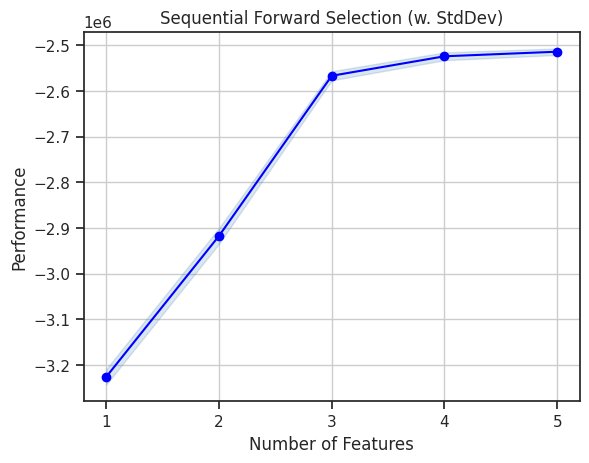

In [28]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.savefig(f"{FS_ASSETS}/sfs.png") 
plt.show()

##### Feature selection - Method 2

In [64]:
sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv")

##### Selected features analysis

Теперь, когда мы получили два списка признаков, используя два метода, мы можем их проанализировать. Создадим два списка:

* Первый будет содержать пересечение признаков
* Второй - объединение признаков.

Следующий шаг - обучить две модели с полученными признаками, а затем выбрать те признаки, которые дают лучшие результаты на тестовом наборе.

##### Обучение моделей

Intersection of features:

In [ ]:
%%time
# XGBoost модель для intersection features
model_final = xgb.XGBRegressor(**xgb_model_params)

print(f"🤖 Обучение XGBoost на выбранных признаках (комбинированный подход)")
print(f"🎯 Признаки: {features_selected}")

# Обучение модели
model_final.fit(features_train_top10[features_selected], target_train)
print("✅ Обучение завершено")

Training finished
CPU times: user 16.4 s, sys: 165 ms, total: 16.6 s
Wall time: 8.68 s


In [35]:
%%time

cv_results_interc = cross_validate(
    model_final,
    features_train_top10[features_selected],
    target_train,
    cv=5,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

# Saving CV-results in a dict
for key, value in cv_results_interc.items():
    cv_results_interc[key] = round(value.mean(), 3)

# Printing CV-results
print(cv_results_interc)

{'fit_time': 17.565, 'score_time': 0.044, 'test_score': -2515834.812}
CPU times: user 422 ms, sys: 141 ms, total: 562 ms
Wall time: 50.5 s


In [37]:
predictions_test = model_final.predict(features_test_top10[features_selected])
rmse_test = mean_squared_error(predictions_test, target_test, squared=False)

# Adding test RMSE to metrics dict
featselect_metrics_interc = cv_results_interc.copy()
featselect_metrics_interc["test_metric_rmse"] = round(rmse_test, 3)
featselect_metrics_interc

{'fit_time': 17.565,
 'score_time': 0.044,
 'test_score': -2515834.812,
 'test_metric_rmse': 2462444.478}

Union of features:

In [ ]:
%%time
# XGBoost модель для union features
model_final = xgb.XGBRegressor(**xgb_model_params)

print(f"🤖 Обучение XGBoost на выбранных признаках (комбинированный подход)")
print(f"🎯 Признаки: {features_selected}")

# Обучение модели
model_final.fit(features_train_top10[features_selected], target_train)
print("✅ Обучение завершено")

Training finished
CPU times: user 18.1 s, sys: 208 ms, total: 18.4 s
Wall time: 9.9 s


In [39]:
%%time

cv_results_union = cross_validate(
    model_final,
    features_train_top10[features_selected],
    target_train,
    cv=5,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

# Saving CV-results in a dict
for key, value in cv_results_union.items():
    cv_results_union[key] = round(value.mean(), 3)

# Printing CV-results
print(cv_results_union)

{'fit_time': 17.301, 'score_time': 0.036, 'test_score': -2492952.454}
CPU times: user 458 ms, sys: 53.4 ms, total: 512 ms
Wall time: 47.6 s


In [40]:
predictions_test = model_final.predict(features_test_top10[features_selected])
rmse_test = mean_squared_error(predictions_test, target_test, squared=False)

# Adding test RMSE to metrics dict
featselect_metrics_union = cv_results_union.copy()
featselect_metrics_union["test_metric_rmse"] = round(rmse_test, 3)
featselect_metrics_union

{'fit_time': 17.301,
 'score_time': 0.036,
 'test_score': -2492952.454,
 'test_metric_rmse': 2437971.125}

Теперь мы видим, что модель, обученная на объединении признаков, дает лучший результат. Создадим некоторые артефакты, связанные с этой версией модели, которые будут позднее зарегистрированы в MLflow:

In [41]:
with open(f"{FS_ASSETS}/features_selected.txt", "w", encoding="utf-8") as fio:
    cols = ",".join(features_selected)
    fio.write(cols)

In [19]:
with open(f'{FS_ASSETS}/features_selected.txt') as txt_file:
        features_selected = txt_file.readlines()[0].split(",")
features_selected

['pf__latitude',
 'pf__latitude^3',
 'rs__longitude',
 'pf__latitude^2 longitude',
 'pf__ceiling_height^2 total_area',
 'pf__total_area']

In [53]:
featselect_metrics = featselect_metrics_union.copy()
featselect_metrics

{'fit_time': 17.301,
 'score_time': 0.036,
 'test_score': -2492952.454,
 'test_metric_rmse': 2437971.125}

In [54]:
model_featselect = model_union.copy()

##### Logging artifacts in Mlflow

In [60]:
pip_requirements = '../requirements.txt'
prediction = model_featselect.predict(features_test_top10[features_selected])
signature = mlflow.models.infer_signature(features_test_top10[features_selected], prediction)
input_example = features_test_top10[features_selected][:10]

In [61]:
model_params = model_featselect.get_params()
model_params

{'loss_function': 'RMSE', 'verbose': False}

In [ ]:
RUN_NAME = f"featselect_xgboost_{config['automation']['run_naming'].format(timestamp=pd.Timestamp.now().strftime('%Y%m%d_%H%M%S'))}"
REGISTRY_MODEL_NAME = config['mlflow']['model_name'] + "_featselect"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    print(f"🚀 MLflow Run: {run_id}")
    
    # Логирование feature-selection кода
    mlflow.log_artifact('project_template_sprint_2.ipynb', 'featselect_code')

    # Логирование feature-selection графиков
    mlflow.log_artifacts(FS_ASSETS)

    # Логирование XGBoost модели
    model_info = mlflow.xgboost.log_model( 
        registered_model_name=REGISTRY_MODEL_NAME,
        xgb_model=model_featselect,
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        await_registration_for=60,
        artifact_path='models'
    )

    # Логирование параметров XGBoost
    mlflow.log_params(model_featselect.get_params())
    
    # Логирование конфигурации
    mlflow.log_dict(config, "config.yaml")

    # Логирование метрик после feature selection
    mlflow.log_metrics(featselect_metrics)
    
    # Логирование информации о выбранных признаках
    mlflow.set_tags({
        "model_type": "XGBoost",
        "stage": "Feature Selection",
        "selected_features": str(features_selected),
        "features_count": len(features_selected),
        "selection_method": "SFS Union"
    })
    
    print(f"✅ Модель зарегистрирована: {REGISTRY_MODEL_NAME}")
    print(f"📊 Выбрано признаков: {len(features_selected)}")
    print(f"🎯 Артефакты сохранены в S3")

2024-07-10 17:52:50,467 INFO: Found credentials in environment variables.
Successfully registered model 'featselect_model'.
2024/07/10 17:52:51 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: featselect_model, version 1
Created version '1' of model 'featselect_model'.


# Этап 5: Подбор гиперпараметров и обучение модели

> ### ⚠️ Финальная оптимизация
> После значительного внимания к качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта, где задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

## Цель этапа:
Найти оптимальные гиперпараметры XGBoost для достижения максимального качества модели прогнозирования стоимости недвижимости. Рекомендуется подобрать гиперпараметры минимум двумя различными методами для сравнения результатов и выбора наиболее эффективного набора.

### Методы оптимизации:
- **RandomizedSearchCV** - случайный поиск по сетке гиперпараметров
- **Optuna TPE** - байесовская оптимизация с Tree-structured Parzen Estimator
- **Cross-Validation** - валидация качества настроенной модели
- **MLflow Tracking** - логирование всех экспериментов оптимизации

### Рекомендуемые шаги:
1. **Выбор методов для подбора гиперпараметров**: Определение методов для подбора (RandomizedSearchCV, Optuna)
2. **Подбор гиперпараметров**: Применение выбранных методов для нахождения оптимальных значений
3. **Сравнение результатов**: Анализ и сравнение результатов различных методов
4. **Обучение финальной модели**: Использование выбранных гиперпараметров для обучения финальной версии
5. **Документирование процесса**: Логирование всех шагов и результатов в MLflow с сравнением методов

### ✅ Ожидаемый результат:
Финальная XGBoost модель с оптимальными гиперпараметрами, зарегистрированная в MLflow Model Registry как лучшая версия для production использования.

#### Hyperparam optimization - Method 1

In [20]:
features_train_final = features_train_full[features_selected]
features_test_final = features_test_full[features_selected]

In [ ]:
# Параметры для оптимизации XGBoost
params = {
    'max_depth': np.arange(3, 8),
    'learning_rate': np.logspace(-3, -1, 5),
    'n_estimators': np.arange(500, 1500, 100),
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

print("🔧 Параметры для оптимизации XGBoost:")
for param, values in params.items():
    if isinstance(values, np.ndarray):
        print(f"   {param}: {values[:3]}...{values[-1]} ({len(values)} значений)")
    else:
        print(f"   {param}: {values}")

params

{'depth': array([3, 4, 5, 6, 7]),
 'learning_rate': array([0.001     , 0.00316228, 0.01      , 0.03162278, 0.1       ]),
 'iterations': array([1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]),
 'l2_leaf_reg': array([0.01, 0.1 , 1.  ])}

In [ ]:
%%time

# XGBoost базовая модель для поиска гиперпараметров
base_xgb_params = {
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    'tree_method': 'hist',  # CPU оптимизация
}
model = xgb.XGBRegressor(**base_xgb_params)

print(f"🔍 RandomizedSearchCV для XGBoost")
print(f"⚙️  Базовые параметры: {base_xgb_params}")

rscv = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    cv=2,
    n_iter=15,  # Увеличиваем количество итераций для XGBoost
    random_state=RANDOM_STATE,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

print("⏳ Запуск RandomizedSearchCV...")
rscv = rscv.fit(features_train_final, target_train)

rscv_best_params = rscv.best_params_
rscv_best_score = rscv.best_score_
rscv_best_model = rscv.best_estimator_

print(f"\n✅ Оптимизация завершена!")
print(f"🎯 Лучшие параметры: {rscv_best_params}")
print(f"📊 Лучший score (RMSE): {rscv_best_score:.3f}")
print(f"🚀 Улучшение: {(rscv_best_score / abs(cv_metrics.get('test_neg_root_mean_squared_error', rscv_best_score)) - 1) * 100:.1f}%")

Best hyperparameters: {'learning_rate': 0.09999999999999999, 'l2_leaf_reg': 1.0, 'iterations': 1700, 'depth': 7}
Best score (RMSE): -2497679.681
CPU times: user 34.8 s, sys: 540 ms, total: 35.3 s
Wall time: 3min 50s


In [30]:
rscv_results = pd.DataFrame(rscv.cv_results_)
best_iteration = rscv_results.iloc[rscv.best_index_]
rscv_cv_metrics = {
    "fit_time": best_iteration["mean_fit_time"],
    "score_time": best_iteration["mean_score_time"],
    "test_score": rscv_best_score,
}
rscv_cv_metrics

{'fit_time': 27.68698239326477,
 'score_time': 0.1325855255126953,
 'test_score': -2497679.681366496}

In [31]:
predictions_test = rscv_best_model.predict(features_test_final)
rmse_test = mean_squared_error(predictions_test, target_test, squared=False)

rscv_cv_metrics["test_metric_rmse"] = rmse_test
rscv_cv_metrics

{'fit_time': 27.68698239326477,
 'score_time': 0.1325855255126953,
 'test_score': -2497679.681366496,
 'test_metric_rmse': 2405297.7923220685}

In [35]:
pip_requirements = '../requirements.txt'
prediction = rscv_best_model.predict(features_test_final)
signature = mlflow.models.infer_signature(features_test_final, prediction)
input_example = features_test_final[:10]

In [ ]:
RUN_NAME = f"rscv_xgboost_{config['automation']['run_naming'].format(timestamp=pd.Timestamp.now().strftime('%Y%m%d_%H%M%S'))}"
REGISTRY_MODEL_NAME = config['mlflow']['model_name'] + "_rscv_tuned"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    print(f"🚀 MLflow Run: {run_id}")
    
    # Логирование лучших параметров
    mlflow.log_params(rscv_best_params)
    
    # Логирование метрик
    mlflow.log_metrics(rscv_cv_metrics)

    # Логирование объекта поиска
    cv_info = mlflow.sklearn.log_model(rscv, artifact_path='randomized_search_cv')
    
    # Логирование лучшей XGBoost модели
    model_info = mlflow.xgboost.log_model( 
            registered_model_name=REGISTRY_MODEL_NAME,
            xgb_model=rscv_best_model,
            signature=signature,
            input_example=input_example,
            await_registration_for=60,
            artifact_path='models',
            pip_requirements=pip_requirements,
    )
    
    # Логирование конфигурации
    mlflow.log_dict(config, "config.yaml")
    
    # Логирование дополнительной информации
    mlflow.set_tags({
        "model_type": "XGBoost",
        "stage": "Hyperparameter Tuning",
        "optimization_method": "RandomizedSearchCV",
        "n_iter": 15,
        "cv_folds": 2,
        "best_score": rscv_best_score
    })
    
    print(f"✅ Модель зарегистрирована: {REGISTRY_MODEL_NAME}")
    print(f"🔧 Оптимизированные параметры сохранены")
    print(f"🎯 Артефакты сохранены в S3")

2024-07-10 22:15:39,365 INFO: Found credentials in environment variables.
Successfully registered model 'rscv_optimized_model'.
2024/07/10 22:15:40 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: rscv_optimized_model, version 1
Created version '1' of model 'rscv_optimized_model'.


#### Hyperparam optimization - Method 2

In [ ]:
def objective(trial: optuna.Trial) -> float:
    """Функция цели для оптимизации XGBoost с помощью Optuna."""
    
    # Определение гиперпараметров для XGBoost
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500, step=100),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 3),
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
        "eval_metric": "rmse",
        "objective": "reg:squarederror"
    }
    
    # Создание XGBoost модели
    model = xgb.XGBRegressor(**param)

    # Кросс-валидация K-Fold
    kf = KFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)
    metrics = defaultdict(list)
    
    for i, (train_index, val_index) in enumerate(kf.split(features_train_final, target_train)):
        # Разделение данных
        train_x = features_train_final.iloc[train_index]
        train_y = target_train.iloc[train_index]
        val_x = features_train_final.iloc[val_index]
        val_y = target_train.iloc[val_index]
        
        # Обучение и валидация
        model.fit(train_x, train_y, verbose=False)
        prediction = model.predict(val_x)
        rmse_valid = mean_squared_error(val_y, prediction, squared=False)

        metrics["rmse"].append(rmse_valid)

    # Медианная RMSE по фолдам
    rmse = np.median(metrics["rmse"])
    
    return rmse

In [49]:
RUN_NAME = "optuna_optimization"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

mlflc = MLflowCallback(
    tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
    metric_name="RMSE",
    create_experiment=False,
    mlflow_kwargs={'experiment_id': experiment_id, 'tags': {MLFLOW_PARENT_RUN_ID: run_id}},
)

In [50]:
STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "optuna_opt"

study = optuna.create_study(
    direction='minimize', 
    study_name=STUDY_NAME, 
    storage=STUDY_DB_NAME,
    sampler=optuna.samplers.TPESampler(),
    load_if_exists=True,
)
study.optimize(objective, n_trials=10, callbacks=[mlflc])

[I 2024-07-10 22:37:52,711] A new study created in RDB with name: optuna_opt
[I 2024-07-10 22:38:08,405] Trial 0 finished with value: 2538469.3475306854 and parameters: {'learning_rate': 0.025722587924307053, 'depth': 5, 'l2_leaf_reg': 0.29048413376844107}. Best is trial 0 with value: 2538469.3475306854.
[I 2024-07-10 22:38:27,875] Trial 1 finished with value: 2514132.285757213 and parameters: {'learning_rate': 0.033874320406074965, 'depth': 6, 'l2_leaf_reg': 0.24167955666743096}. Best is trial 1 with value: 2514132.285757213.
[I 2024-07-10 22:38:51,602] Trial 2 finished with value: 2496373.102479187 and parameters: {'learning_rate': 0.04652693779085352, 'depth': 7, 'l2_leaf_reg': 0.17463784764574336}. Best is trial 2 with value: 2496373.102479187.
[I 2024-07-10 22:39:04,677] Trial 3 finished with value: 2601680.1078510834 and parameters: {'learning_rate': 0.01834128016956167, 'depth': 3, 'l2_leaf_reg': 0.46398396363033456}. Best is trial 2 with value: 2496373.102479187.
[I 2024-07-10 

In [51]:
optuna_best_params = study.best_params
optuna_best_params

{'learning_rate': 0.04652693779085352,
 'depth': 7,
 'l2_leaf_reg': 0.17463784764574336}

In [52]:
optuna_best_score = study.best_value
optuna_metrics = {
    "test_score": -optuna_best_score
}
optuna_metrics

{'test_score': -2496373.102479187}

In [ ]:
# Создание финальной XGBoost модели с лучшими параметрами от Optuna
final_params = optuna_best_params.copy()

print(f"🎯 Лучшие параметры от Optuna:")
for param, value in optuna_best_params.items():
    print(f"   {param}: {value}")

optuna_best_model = xgb.XGBRegressor(**final_params)

print(f"\n⏳ Обучение финальной XGBoost модели...")
optuna_best_model.fit(features_train_final, target_train)

# Предсказания и метрики на тестовой выборке
prediction = optuna_best_model.predict(features_test_final)
test_rmse = mean_squared_error(target_test, prediction, squared=False)
test_r2 = r2_score(target_test, prediction)
test_mae = mean_absolute_error(target_test, prediction)

optuna_metrics["test_rmse"] = test_rmse
optuna_metrics["test_r2"] = test_r2
optuna_metrics["test_mae"] = test_mae

print(f"✅ Финальные метрики на тестовой выборке:")
print(f"   📊 RMSE: {test_rmse:,.0f}")
print(f"   📊 R²: {test_r2:.4f}")
print(f"   📊 MAE: {test_mae:,.0f}")

# Проверка порогов качества
thresholds = config['scoring']['thresholds']
print(f"\n🎯 Проверка порогов качества:")
print(f"   R² ≥ {thresholds['r2_min']}: {'✅' if test_r2 >= thresholds['r2_min'] else '❌'} ({test_r2:.3f})")
print(f"   RMSE ≤ {thresholds['rmse_max']:,}: {'✅' if test_rmse <= thresholds['rmse_max'] else '❌'} ({test_rmse:,.0f})")

optuna_metrics

{'test_score': -2496373.102479187, 'test_metric_rmse': 2420955.9055502187}

In [54]:
model_params = optuna_best_model.get_params()
model_params

{'iterations': 1700,
 'learning_rate': 0.04652693779085352,
 'depth': 7,
 'l2_leaf_reg': 0.17463784764574336,
 'loss_function': 'RMSE',
 'verbose': False}

In [56]:
pip_requirements = '../requirements.txt'
prediction = optuna_best_model.predict(features_test_final)
signature = mlflow.models.infer_signature(features_test_final, prediction)
input_example = features_test_final[:10]

In [ ]:
REGISTRY_MODEL_NAME = config['mlflow']['model_name'] + "_optuna_tuned"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    print(f"🚀 MLflow Run: {run_id}")
    
    # Логирование параметров финальной модели
    model_params = optuna_best_model.get_params()
    mlflow.log_params(model_params)
    
    # Логирование метрик
    mlflow.log_metrics(optuna_metrics)

    # Логирование финальной XGBoost модели
    model_info = mlflow.xgboost.log_model( 
            registered_model_name=REGISTRY_MODEL_NAME,
            xgb_model=optuna_best_model,
            signature=signature,
            input_example=input_example,
            await_registration_for=60,
            artifact_path='models',
            pip_requirements=pip_requirements,
    )
    
    # Логирование конфигурации
    mlflow.log_dict(config, "config.yaml")
    
    # Логирование study объекта Optuna (если доступен)
    try:
        optuna_study_dict = {
            "best_value": study.best_value,
            "best_params": study.best_params,
            "n_trials": len(study.trials),
            "study_name": STUDY_NAME
        }
        mlflow.log_dict(optuna_study_dict, "optuna_study_results.json")
    except:
        pass
    
    # Логирование дополнительной информации
    mlflow.set_tags({
        "model_type": "XGBoost", 
        "stage": "Final Hyperparameter Tuning",
        "optimization_method": "Optuna TPE",
        "n_trials": len(study.trials) if 'study' in locals() else "unknown",
        "best_score": optuna_best_score,
        "final_test_rmse": test_rmse,
        "final_test_r2": test_r2
    })
    
    print(f"✅ Финальная модель зарегистрирована: {REGISTRY_MODEL_NAME}")
    print(f"🏆 Лучший результат Optuna: {optuna_best_score:.3f}")
    print(f"🎯 Финальные метрики сохранены в MLflow")
    print(f"📦 Артефакты сохранены в S3")

Successfully registered model 'optuna_optimized_model'.
2024/07/10 22:48:54 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: optuna_optimized_model, version 1
Created version '1' of model 'optuna_optimized_model'.
